# Instruções:

Para baixar o conjunto de dados, acessar o seguinte link:\
https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/ \
O conjunto de dados é o 4. Bearing Data Set\
Baixar os conjuntos de dados e descomprimir estas pastas na pasta raiz do github.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import os, math, time, random
from datetime import datetime
from sklearn.neural_network import MLPClassifier

# Definições

## SFAM

In [2]:
class SFAM:
    def _norm(self, X):
        result = 0.0
        for i in range(self.input_size):
            result = + abs(X[i])
        return result

    def _and_fuzzy_norm(self, X, Y):
        AND = []
        for i in range(self.input_size):
            AND.append(min(X[i], Y[i]))

        return self._norm(AND)

    def _train(self, X, W):
        result = []
        for i in range(self.input_size):
            result.append(self.beta * min(X[i], W[i]) + (1 - self.beta) * W[i])

        return result
    
    def __init__(self, input_size=6, alpha=1e-5, rho=0.001, beta=1.0, epsilon=0.0, uncommited_value=0.5):
        self.rho = rho
        self.beta = beta
        self.alpha = alpha
        self.epsilon = epsilon
        self.input_size = 2 * input_size

        ZERO = []
        M = []

        for _ in range(self.input_size):
            ZERO.append(0.0)
            M.append(0.5)

        self.used = []

        self.categories = []
        self.W = []
        self.ZERO = ZERO
        self.m = self._norm(M)
        self.uncommited_value = uncommited_value

    def train(self, X, y):
        rho = self.rho
        Xc = []
        for x in X:
            Xc.append(1.0 - x)
        X = X.copy()
        X.extend(Xc)

        t = []
        fuzzy_and = []
        for i in range(len(self.W)):
            fuzzy_and.append(self._and_fuzzy_norm(X, self.W[i]))
            t.append(fuzzy_and[i] / (self.alpha + self._norm(self.W[i])))

        train_finished = False
        stable = True

        while not train_finished:
            winner = -1
            winner_value = -1
            for i in range(len(t)):
                if t[i] > winner_value:
                    winner_value = t[i]
                    winner = i

            if self.uncommited_value > winner_value:
                self.W.append(X)
                self.categories.append(y)
                self.used.append(False)

                train_finished = True
                stable = False
            else:
                fuzzy_and_m = fuzzy_and[winner] / self.m
                if fuzzy_and_m > rho:
                    if self.categories[winner] == y:
                        self.W[winner] = self._train(X, self.W[winner])
                        train_finished = True
                    else:
                        rho = fuzzy_and_m + self.epsilon
                        t[winner] = -1
                        if (rho >= 1.0):
                            train_finished = True
                else:
                    t[winner] = -1

        return stable

    def predict(self, X):
        Xc = []
        for x in X:
            Xc.append(1.0 - x)
        X = X.copy()
        X.extend(Xc)

        t = []
        fuzzy_and = []
        for i in range(len(self.W)):
            fuzzy_and.append(self._and_fuzzy_norm(X, self.W[i]))
            t.append(fuzzy_and[i] / (self.alpha + self._norm(self.W[i])))

        winner = -1
        winner_value = -1
        for i in range(len(t)):
            if t[i] > winner_value:
                winner_value = t[i]
                winner = i
        self.used[winner] = True
        return self.categories[winner]

    def prune(self):
        finished = False
        while not finished:
            _break = False
            for i in range(len(self.W)):
                if not self.used[i]:
                    del self.W[i]
                    del self.categories[i]
                    del self.used[i]
                    _break = True
                    break
            if not _break:
                finished = True

    def print(self):
        for i in range(len(self.W)):
            print(self.W[i], self.categories[i], self.used[i])
            
    def shuffle_nasa_train(self, data, init_degeneration=-1, order=2):
        X, y = organize_nasa(data, init_degeneration, order)
        for i in range(len(X)):
            X[i].append(y[i])
        stable = True
        random.seed(0)
        while stable:
            random.shuffle(X)
            for i in range(len(X)):
                result = self.train(X[i][:-1], X[i][-1])
                stable = stable and result
        

    def train_nasa(self, data, init_degeneration=-1, order=2):
        X, y = organize_nasa(data, init_degeneration, order)
        stable = True
        while stable:
            for i in range(len(X)):
                result = self.train(X[i], y[i])
                stable = stable and result

    def predict_nasa(self, data, init_degeneration=-1, order=2, plot=True):
        X, y = organize_nasa(data, init_degeneration, order)
        p = []
        ok = 0
        for i in range(len(X)):
            p.append(self.predict(X[i]))
            if p[i] == y[i]:
                ok += 1
            p[-1] *= (100.0 / 6.0)
        if plot:
            plt.plot(p, 'ro')
            plt.plot(smoothing(p))
        return ok / len(X)

## Kusaba SFAM

In [3]:
def minimum(A,B):
    ans=[]
    for i in range(len(A)):
        #print("I and W sizes: ", len(A), len(B))
        ans.append(min([A[i],B[i]]))
        
    ans = np.array(ans)
    return ans
    
def complement_code(X):
        I = np.hstack((X, 1-X))
        return I
    
    
def one_hot_encode(labels):
    print(labels[0])
    one_hot_labels = np.zeros((labels.shape[0], 10))
    for i in range(labels.shape[0]):
        one_hot_labels[i, labels[i]] = 1
    return one_hot_labels
    
class simplified_fuzzy_ARTMAP:
    
    def __init__(self, X_size, label_size, c_max_a, rho_a, rho_ab, alpha=0.00001, beta=1):
        self.M_a = X_size    # input vector size
        self.M_ab = label_size    # input label vector size
        
        self.c_max_a = c_max_a # max categories for ART-a
        
        
        self.rho_a = rho_a    # vigilance parameter for ART-a
        self.rho_a_baseline = rho_a
        self.rho_ab = rho_ab  # vigilance parameter for map field
        self.alpha = alpha # choice parameter
        self.beta = beta   # learning rate
        
        self.N_a = 0         # no. of categories of ART_a initialized to zero
        
        self.W_a = np.ones( (c_max_a, self.M_a*2) ) # initialize W_a with 1s
        self.W_ab = np.ones( (self.M_ab, c_max_a) ) # initialize W_ab with 1s
        
        self.X_ab = np.zeros( (self.M_ab,) )
    
    def train(self, X, one_hot_labels, rho_a_inc_rate=0.001):
        A = complement_code(X)   # shape of X = Mx1, shape of I = 2Mx1
        B = one_hot_labels
         
        self.rho_a =  self.rho_a_baseline
         
        T = []
        for i in range(self.N_a):           
            T.append( np.sum(minimum(A,self.W_a[i,:])) / (self.alpha+np.sum(self.W_a[i,:])) ) # calculate output
        
        J_list = np.argsort(np.array(T))[::-1]  # J_list: indices of F2 nodes with decreasing order of activations        
        
        for J in J_list:
            # Checking for resonance in ART-a  ---
            X_a_mod = np.sum(minimum(A,self.W_a[J,:])) 
                
            while X_a_mod >= self.rho_a * np.sum(A): # resonance occured in ART-a 
                
                #####  match tracking  #####
                # Checking for resonance in the MAP FIELD  ---
                   
                self.X_ab_mod = np.sum( minimum( B,self.W_ab[:,J] ) )
                
                if self.X_ab_mod > self.rho_ab * np.sum(B): # resonance occurs in the MAP FIELD
                    # weight update
                    self.W_a[J,:] = self.beta*minimum(A,self.W_a[J,:]) + (1-self.beta)*self.W_a[J,:] # weight update of ART-a
                    K = np.argmax( B )
                    self.W_ab[:,J] = 0
                    self.W_ab[K,J] = 1
                    return self.W_ab, K
                
                else: # NO resonance in the MAP FIELD
                    self.rho_a += rho_a_inc_rate
       
        if self.N_a < self.c_max_a:    # no resonance occured in ART-a, create a new category
            n = self.N_a
            self.W_a[n,:] = self.beta*minimum(A,self.W_a[n,:]) + (1-self.beta)*self.W_a[n,:] # weight update
            self.N_a += 1
            
            K = np.argmax( B )
            self.W_ab[:,n] = 0
            self.W_ab[K,n] = 1
            return self.W_ab, K
        
        if self.N_a >= self.c_max_a:
            print("ART-a memory error!")
            return None, None
    
    def infer(self, X):
        A = complement_code(X)   
        T = []
        for i in range(self.N_a):           
            T.append( np.sum(minimum(A,self.W_a[i,:])) / (self.alpha+np.sum(self.W_a[i,:])) ) # calculate output        
        #J_list = np.argsort(np.array(T))[::-1]  # J_list: indices of F2 nodes with decreasing order of activations        
        #J = J_list[0] # maximum activation
        J = np.argmax(np.array(T))
        X_ab = self.W_ab[:,J] 
        return X_ab

## Utils

In [4]:
def smoothing(y, si = 6):
    result = [y[0]]
    for i in range(1, len(y)):
        rul = y[i]
        for _ in range(si):
            rul = (result[-1] + rul) / 2.0
        result.append(rul)
    return result

def clip(vector, init=0.0, end=1.0):
    vector = vector.copy()
    for i in range(len(vector)):
        vector[i] = (vector[i] - init) / (end - init)
        if vector[i] > 1.0:
            vector[i] = 1.0
        elif vector[i] < 0.0:
            vector[i] = 0.0
    return vector

def organize_nasa(data, init_degeneration=-1, order=2):
    X = []
    y = []
    len_data = len(data('rms'))
    for i in range(order - 1, len_data):
        categoric_label = None
        if init_degeneration > 0:
            new_i = i - init_degeneration
            if new_i > 0:
                current_label = new_i / (len_data - init_degeneration)
            else:
                current_label = 0.0
        else:
            current_label = i / len_data
        if current_label < 0.1:
            categoric_label = 0
        elif current_label < 0.25:
            categoric_label = 1
        elif current_label < 0.4:
            categoric_label = 2
        elif current_label < 0.55:
            categoric_label = 3
        elif current_label < 0.7:
            categoric_label = 4
        elif current_label < 0.85:
            categoric_label = 5
        else:
            categoric_label = 6
        X.append([])
        for j in range(order):
            X[-1].append(data('rms')[i - j][0])
        for j in range(order):
            X[-1].append(data('kurtosis')[i - j][0])
        for j in range(order):
            X[-1].append(data('rmsee')[i - j][0])
        y.append(categoric_label)
    return X, y

## Normalizations factories

In [5]:
def apply_normalization(data, key_norm, norm):
    data[key_norm] = {}
    data[key_norm]['scaler'] = norm
    data[key_norm]['data'] = data['data'].reshape((-1, 1))
    data[key_norm]['scaler'].fit(data[key_norm]['data'])
    data[key_norm]['data'] = data[key_norm]['scaler'].transform(data[key_norm]['data'])

def apply_fit_normalization(data, key_norm, scaler):
    data[key_norm] = {}
    data[key_norm]['data'] = data['data'].reshape((-1, 1))
    data[key_norm]['data'] = scaler[key_norm]['scaler'].transform(data[key_norm]['data'])

def apply_cumulative_normalization(data, key_norm, new_key_norm, norm):
    data[new_key_norm] = {}
    data[new_key_norm]['scaler'] = norm
    data[new_key_norm]['data'] = data[key_norm]['data'].reshape((-1, 1))
    data[new_key_norm]['scaler'].fit(data[new_key_norm]['data'])
    data[new_key_norm]['data'] = data[new_key_norm]['scaler'].transform(data[new_key_norm]['data'])

## Extract data

In [6]:
def ufrf(t, b, n, y, k):
    return y+(k*(b/(n**b))*(t**(b-1)))

def my_rms(acc):
    return np.sqrt(np.mean(acc**2))

def my_kurt(acc):
    return st.kurtosis(acc, fisher=False)

def extract_data(path, config, step_window=10):
    files_list = os.listdir(path)

    rms = []
    kurtosis = []
    for file in files_list:
        data = pd.read_csv(path+file, sep='\t', header=None)
        rms.append(my_rms(data))
        kurtosis.append(my_kurt(data))

    rms = np.array(rms)
    kurtosis = np.array(kurtosis)
    rms = rms[:, config].copy()
    kurtosis = kurtosis[:, config].copy()

    partial_rmsee = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    for j in range(len(rms) - (step_window - 1)):
        step_rmsee = 0.0
        for i in range(step_window):
            step_rms = rms[j + i]
            step_rmsee += -step_rms*math.log(step_rms)
        step_rmsee /= step_window
        partial_rmsee.append(step_rmsee)

    rmsee = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    for j in range(len(partial_rmsee) - (step_window - 1)):
        step_mean_rmsee = 0.0
        for i in range(step_window):
            step_mean_rmsee += partial_rmsee[j + i]
        step_mean_rmsee /= step_window
        rmsee.append(step_mean_rmsee)

    return np.array(rms), np.array(kurtosis), np.array(rmsee)

# Extraindo dados

## Extraíndo dados de treino

In [7]:
datasets = {}
datasets['train'] = {}

datasets['train']['rms'] = {}
datasets['train']['kurtosis'] = {}
datasets['train']['rmsee'] = {}

datasets['train']['rms']['data'], datasets['train']['kurtosis']['data'], datasets['train']['rmsee']['data'] = extract_data('./2nd_test/', 0)

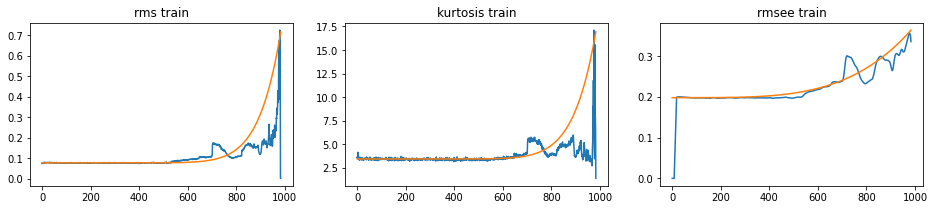

In [8]:
datas = ['rms', 'kurtosis', 'rmsee']

datasets['train']['rms']['ufrf'] = {}
datasets['train']['kurtosis']['ufrf'] = {}
datasets['train']['rmsee']['ufrf'] = {}

datasets['train']['rms']['ufrf']['data'] = []
datasets['train']['kurtosis']['ufrf']['data'] = []
datasets['train']['rmsee']['ufrf']['data'] = []

for i in range(len(datasets['train']['rms']['data'])):
    datasets['train']['rms']['ufrf']['data'].append(ufrf(i, 12.0917, 281.0209, 0.0773, 1.38e-5))
    datasets['train']['kurtosis']['ufrf']['data'].append(ufrf(i, 11.8280, 86.7537,  3.4471, 3.8e-10))
    datasets['train']['rmsee']['ufrf']['data'].append(ufrf(i, 5.0,  100.0, 0.19796, 3.55e-4))
    
datasets['train']['rms']['ufrf']['data'] = np.array(datasets['train']['rms']['ufrf']['data'])
datasets['train']['kurtosis']['ufrf']['data'] = np.array(datasets['train']['kurtosis']['ufrf']['data'])
datasets['train']['rmsee']['ufrf']['data'] = np.array(datasets['train']['rmsee']['ufrf']['data'])

fig, axs = plt.subplots(1, 3, figsize=((16, 3)))

for i in range(len(datas)):
    axs[i].plot(datasets['train'][datas[i]]['data'])
    axs[i].plot(datasets['train'][datas[i]]['ufrf']['data'])
    axs[i].set_title(datas[i] + ' train')

### Normalizações dos dados de treino

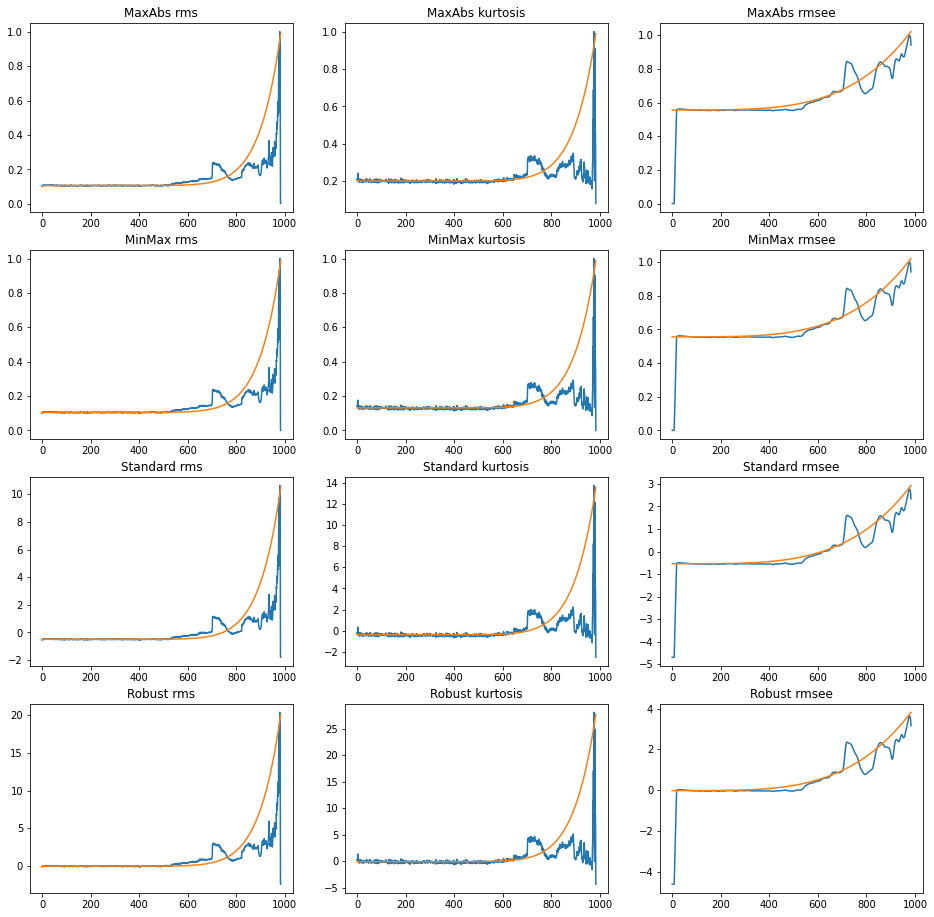

In [9]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler, RobustScaler

keyed_scalers = [('MaxAbs', MaxAbsScaler), ('MinMax', MinMaxScaler), ('Standard', StandardScaler), ('Robust', RobustScaler)]
scalers = ['MaxAbs', 'MinMax', 'Standard', 'Robust']

for scaler_key, scaler in keyed_scalers:
    for key in datas:
        apply_normalization(datasets['train'][key], scaler_key, scaler())
        apply_fit_normalization(datasets['train'][key]['ufrf'], scaler_key, datasets['train'][key])

fig, axs = plt.subplots(4, 3, figsize=((16, 16)))
for i in range(len(datas)):
    for j in range(len(scalers)):
        axs[j][i].plot(datasets['train'][datas[i]][scalers[j]]['data'])
        axs[j][i].plot(datasets['train'][datas[i]]['ufrf'][scalers[j]]['data'])
        axs[j][i].set_title(scalers[j] + ' ' + datas[i])

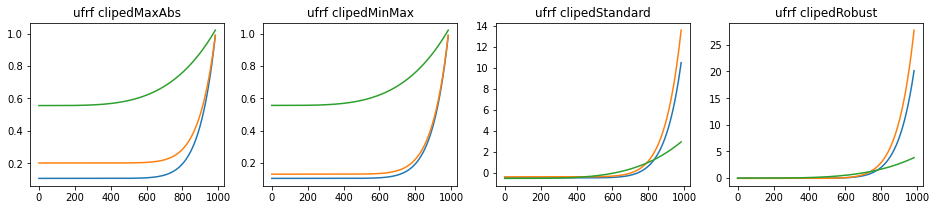

In [10]:
fig, axs = plt.subplots(1, 4, figsize=((16, 3)))

for i in range(len(scalers)):
    axs[i].plot(datasets['train']['rms']['ufrf'][scalers[i]]['data'])
    axs[i].plot(datasets['train']['kurtosis']['ufrf'][scalers[i]]['data'])
    axs[i].plot(datasets['train']['rmsee']['ufrf'][scalers[i]]['data'])
    axs[i].set_title('ufrf cliped' + scalers[i])

### Entre 0.0 e 1.0

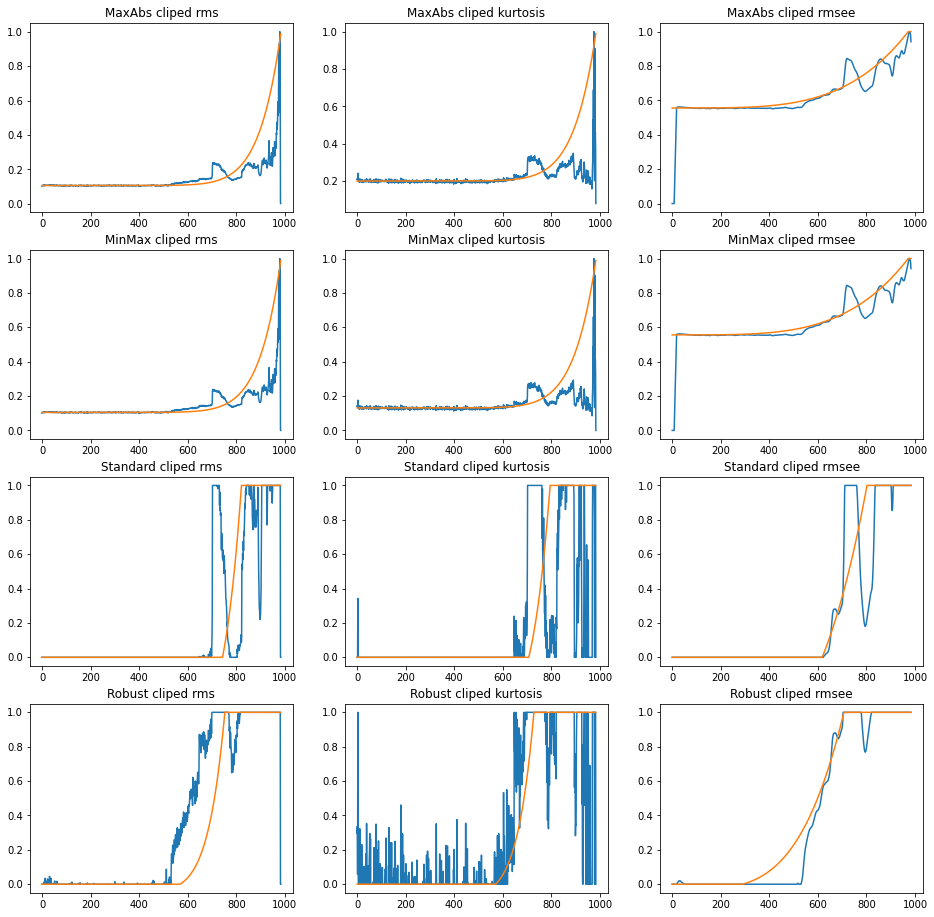

In [11]:
for scaler_key in scalers:
    for key in datas:
        datasets['train'][key][scaler_key + '_Cliped'] = {}
        datasets['train'][key][scaler_key + '_Cliped']['data'] = clip(datasets['train'][key][scaler_key]['data'])
        datasets['train'][key]['ufrf'][scaler_key + '_Cliped'] = {}
        datasets['train'][key]['ufrf'][scaler_key + '_Cliped']['data'] = clip(datasets['train'][key]['ufrf'][scaler_key]['data'])
        
fig, axs = plt.subplots(4, 3, figsize=((16, 16)))
for i in range(len(datas)):
    for j in range(len(scalers)):
        axs[j][i].plot(datasets['train'][datas[i]][scalers[j] + '_Cliped']['data'])
        axs[j][i].plot(datasets['train'][datas[i]]['ufrf'][scalers[j] + '_Cliped']['data'])
        axs[j][i].set_title(scalers[j] + ' cliped ' + datas[i])

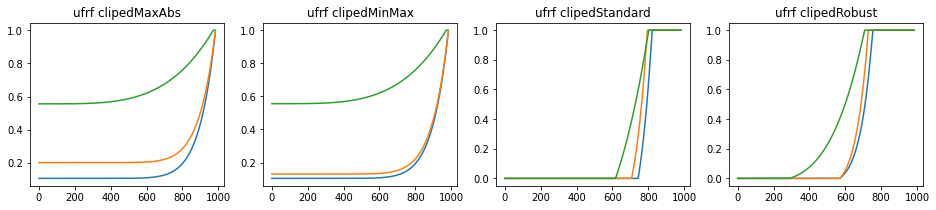

In [12]:
fig, axs = plt.subplots(1, 4, figsize=((16, 3)))

for i in range(len(scalers)):
    axs[i].plot(datasets['train']['rms']['ufrf'][scalers[i] + '_Cliped']['data'])
    axs[i].plot(datasets['train']['kurtosis']['ufrf'][scalers[i] + '_Cliped']['data'])
    axs[i].plot(datasets['train']['rmsee']['ufrf'][scalers[i] + '_Cliped']['data'])
    axs[i].set_title('ufrf cliped' + scalers[i])

### Zoom

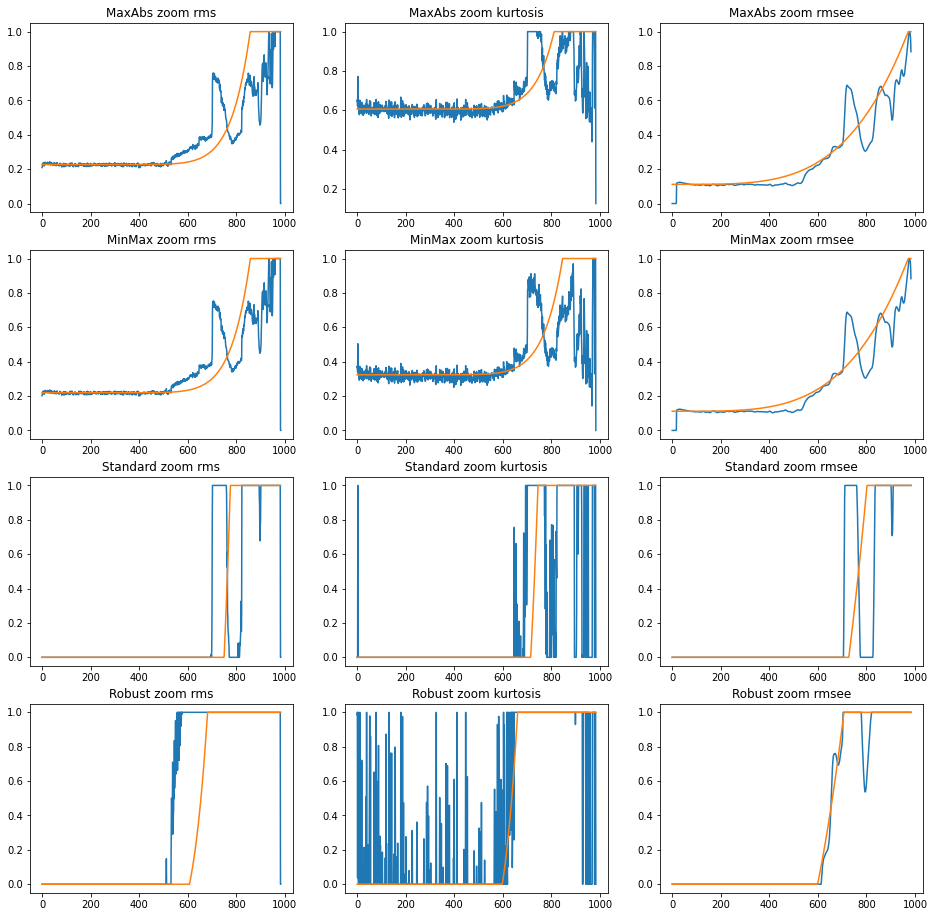

In [13]:
for scaler_key in scalers:
    for key in datas:
        datasets['train'][key][scaler_key + '_Zoom'] = {}
        datasets['train'][key][scaler_key + '_Zoom']['data'] = clip(datasets['train'][key][scaler_key]['data'], init = 0.5 if key == 'rmsee' else 0.05, end = 1.0 if key == 'rmsee' else 0.3)
        datasets['train'][key]['ufrf'][scaler_key + '_Zoom'] = {}
        datasets['train'][key]['ufrf'][scaler_key + '_Zoom']['data'] = clip(datasets['train'][key]['ufrf'][scaler_key]['data'], init = 0.5 if key == 'rmsee' else 0.05, end = 1.0 if key == 'rmsee' else 0.3)
        
fig, axs = plt.subplots(4, 3, figsize=((16, 16)))
for i in range(len(datas)):
    for j in range(len(scalers)):
        axs[j][i].plot(datasets['train'][datas[i]][scalers[j] + '_Zoom']['data'])
        axs[j][i].plot(datasets['train'][datas[i]]['ufrf'][scalers[j] + '_Zoom']['data'])
        axs[j][i].set_title(scalers[j] + ' zoom ' + datas[i])

## Extraindo dados de validação

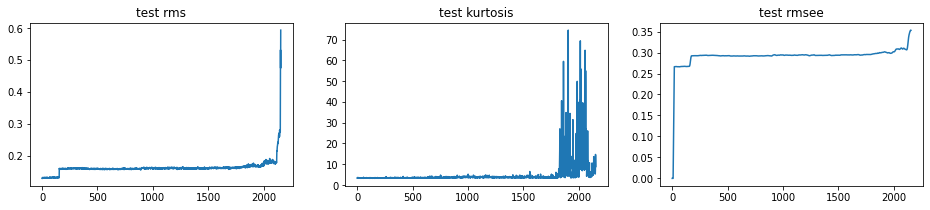

In [14]:
datasets['test'] = {}

datasets['test']['rms'] = {}
datasets['test']['kurtosis'] = {}
datasets['test']['rmsee'] = {}

datasets['test']['rms']['data'], datasets['test']['kurtosis']['data'], datasets['test']['rmsee']['data'] = extract_data('./1st_test/', 4)

fig, axs = plt.subplots(1, 3, figsize=((16, 3)))

for i in range(len(datas)):
    axs[i].plot(datasets['test'][datas[i]]['data'])
    axs[i].set_title('test ' + datas[i])

### Normalização dos dados de validação

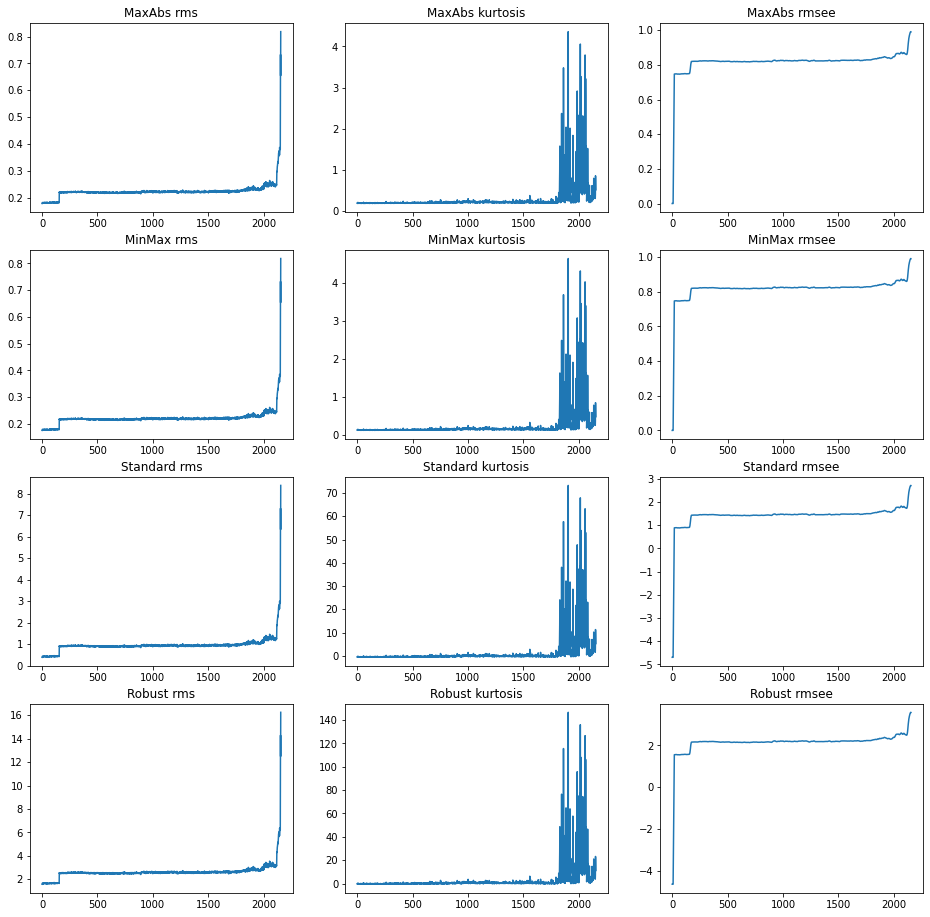

In [15]:
for scaler_key, scaler in keyed_scalers:
    for key in datas:
        apply_fit_normalization(datasets['test'][key], scaler_key, datasets['train'][key])

fig, axs = plt.subplots(4, 3, figsize=((16, 16)))
for i in range(len(datas)):
    for j in range(len(scalers)):
        axs[j][i].plot(datasets['test'][datas[i]][scalers[j]]['data'])
        axs[j][i].set_title(scalers[j] + ' ' + datas[i])

### Entre 0.0 e 1.0

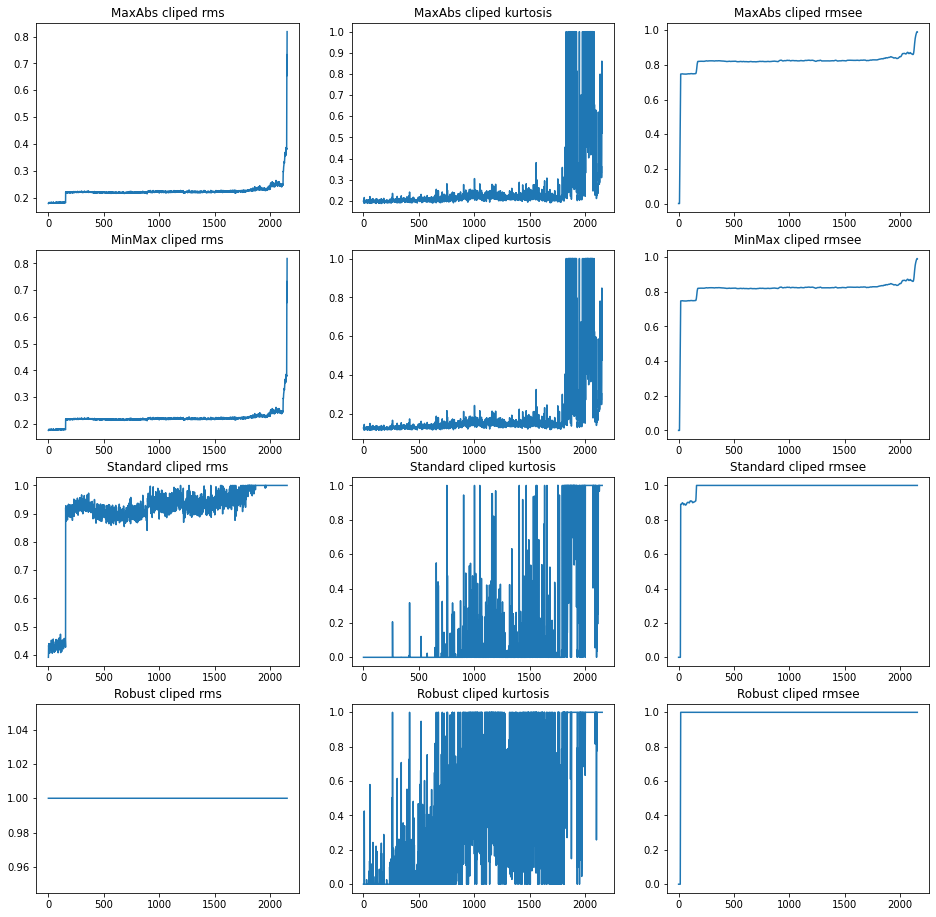

In [16]:
for scaler_key in scalers:
    for key in datas:
        datasets['test'][key][scaler_key + '_Cliped'] = {}
        datasets['test'][key][scaler_key + '_Cliped']['data'] = clip(datasets['test'][key][scaler_key]['data'])
        
fig, axs = plt.subplots(4, 3, figsize=((16, 16)))
for i in range(len(datas)):
    for j in range(len(scalers)):
        axs[j][i].plot(datasets['test'][datas[i]][scalers[j] + '_Cliped']['data'])
        axs[j][i].set_title(scalers[j] + ' cliped ' + datas[i])

### Zoom

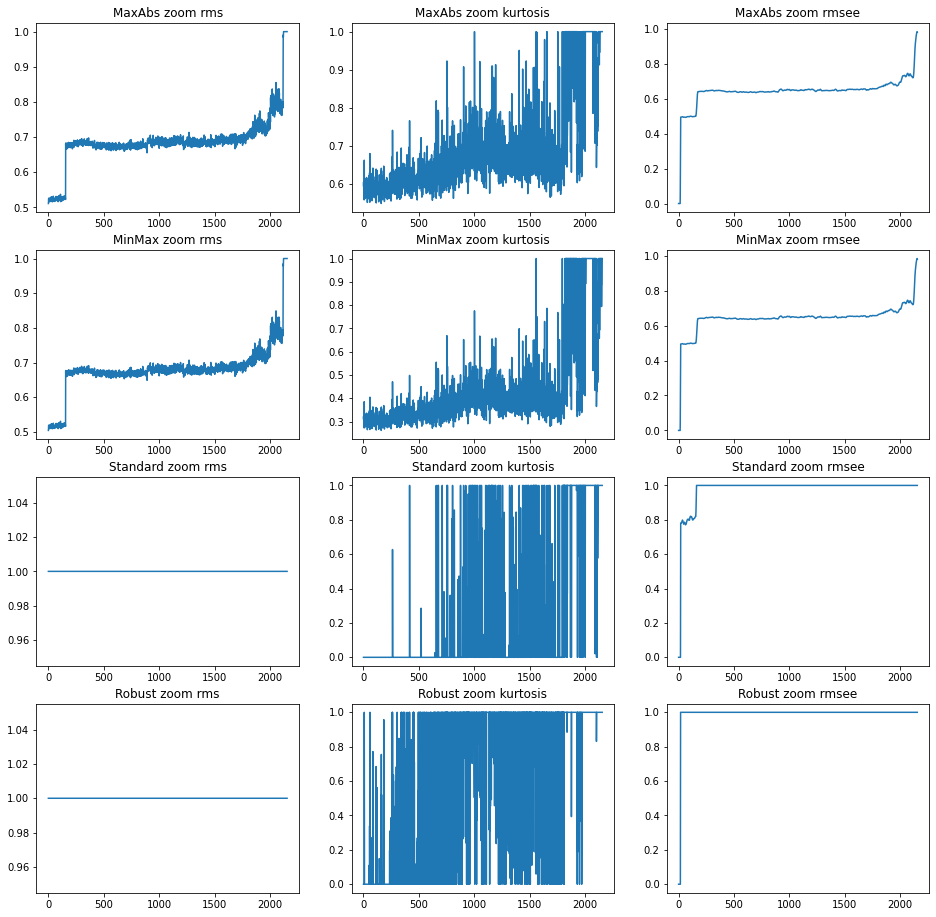

In [17]:
for scaler_key in scalers:
    for key in datas:
        datasets['test'][key][scaler_key + '_Zoom'] = {}
        datasets['test'][key][scaler_key + '_Zoom']['data'] = clip(datasets['test'][key][scaler_key]['data'], init = 0.5 if key == 'rmsee' else 0.05, end = 1.0 if key == 'rmsee' else 0.3)
        
fig, axs = plt.subplots(4, 3, figsize=((16, 16)))
for i in range(len(datas)):
    for j in range(len(scalers)):
        axs[j][i].plot(datasets['test'][datas[i]][scalers[j] + '_Zoom']['data'])
        axs[j][i].set_title(scalers[j] + ' zoom ' + datas[i])

## Centralizando o padrão de operação

### Treino

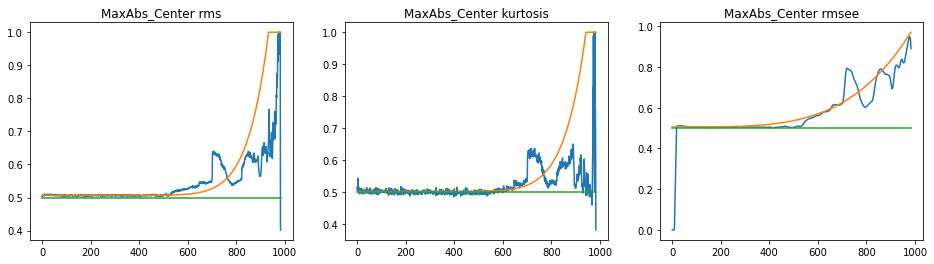

In [18]:
datasets['train']['rms']['MaxAbs_Center'] = {}
datasets['train']['rms']['MaxAbs_Center']['data'] = clip(datasets['train']['rms']['MaxAbs']['data'] + 0.4)
datasets['train']['kurtosis']['MaxAbs_Center'] = {}
datasets['train']['kurtosis']['MaxAbs_Center']['data'] = clip(datasets['train']['kurtosis']['MaxAbs']['data'] + 0.3)
datasets['train']['rmsee']['MaxAbs_Center'] = {}
datasets['train']['rmsee']['MaxAbs_Center']['data'] = clip(datasets['train']['rmsee']['MaxAbs']['data'] - 0.05)
datasets['train']['rms']['ufrf']['MaxAbs_Center'] = {}
datasets['train']['rms']['ufrf']['MaxAbs_Center']['data'] = clip(datasets['train']['rms']['ufrf']['MaxAbs']['data'] + 0.4)
datasets['train']['kurtosis']['ufrf']['MaxAbs_Center'] = {}
datasets['train']['kurtosis']['ufrf']['MaxAbs_Center']['data'] = clip(datasets['train']['kurtosis']['ufrf']['MaxAbs']['data'] + 0.3)
datasets['train']['rmsee']['ufrf']['MaxAbs_Center'] = {}
datasets['train']['rmsee']['ufrf']['MaxAbs_Center']['data'] = clip(datasets['train']['rmsee']['ufrf']['MaxAbs']['data'] - 0.05)

fig, axs = plt.subplots(1, 3, figsize=((16, 4)))
for i in range(len(datas)):
    for j in range(len(['MaxAbs_Center'])):
        axs[i].plot(datasets['train'][datas[i]]['MaxAbs_Center']['data'])
        axs[i].plot(datasets['train'][datas[i]]['ufrf']['MaxAbs_Center']['data'])
        line = []
        for _ in range(len(datasets['train'][datas[i]]['MaxAbs_Center']['data'])):
            line.append(0.5)
        axs[i].plot(line)
        axs[i].set_title('MaxAbs_Center' + ' ' + datas[i])

### Validação

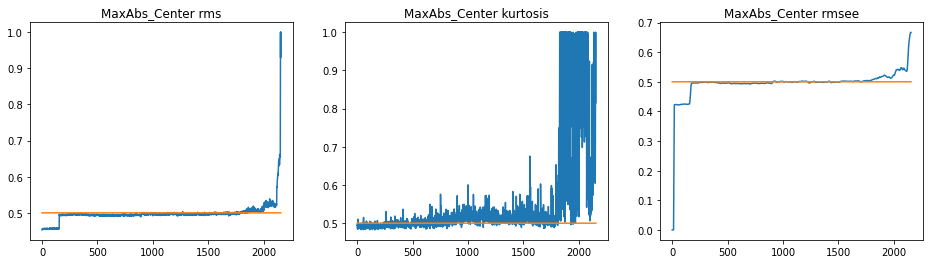

In [19]:
datasets['test']['rms']['MaxAbs_Center'] = {}
datasets['test']['rms']['MaxAbs_Center']['data'] = clip(datasets['test']['rms']['MaxAbs']['data'] + 0.275)
datasets['test']['kurtosis']['MaxAbs_Center'] = {}
datasets['test']['kurtosis']['MaxAbs_Center']['data'] = clip(datasets['test']['kurtosis']['MaxAbs']['data'] + 0.295)
datasets['test']['rmsee']['MaxAbs_Center'] = {}
datasets['test']['rmsee']['MaxAbs_Center']['data'] = clip(datasets['test']['rmsee']['MaxAbs']['data'] - 0.325)

fig, axs = plt.subplots(1, 3, figsize=((16, 4)))
for i in range(len(datas)):
    for j in range(len(['MaxAbs_Center'])):
        axs[i].plot(datasets['test'][datas[i]]['MaxAbs_Center']['data'])
        line = []
        for _ in range(len(datasets['test'][datas[i]]['MaxAbs_Center']['data'])):
            line.append(0.5)
        axs[i].plot(line)
        axs[i].set_title('MaxAbs_Center' + ' ' + datas[i])

## Extraindo dados de validação 2

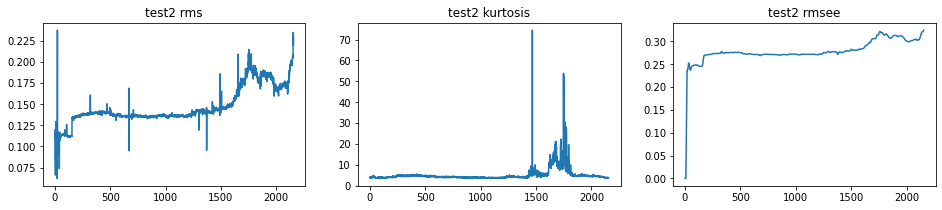

In [20]:
datasets['test2'] = {}

datasets['test2']['rms'] = {}
datasets['test2']['kurtosis'] = {}
datasets['test2']['rmsee'] = {}

datasets['test2']['rms']['data'], datasets['test2']['kurtosis']['data'], datasets['test2']['rmsee']['data'] = extract_data('./1st_test/', 6)

fig, axs = plt.subplots(1, 3, figsize=((16, 3)))

for i in range(len(datas)):
    axs[i].plot(datasets['test2'][datas[i]]['data'])
    axs[i].set_title('test2 ' + datas[i])

### Normalizando dados de validação 2

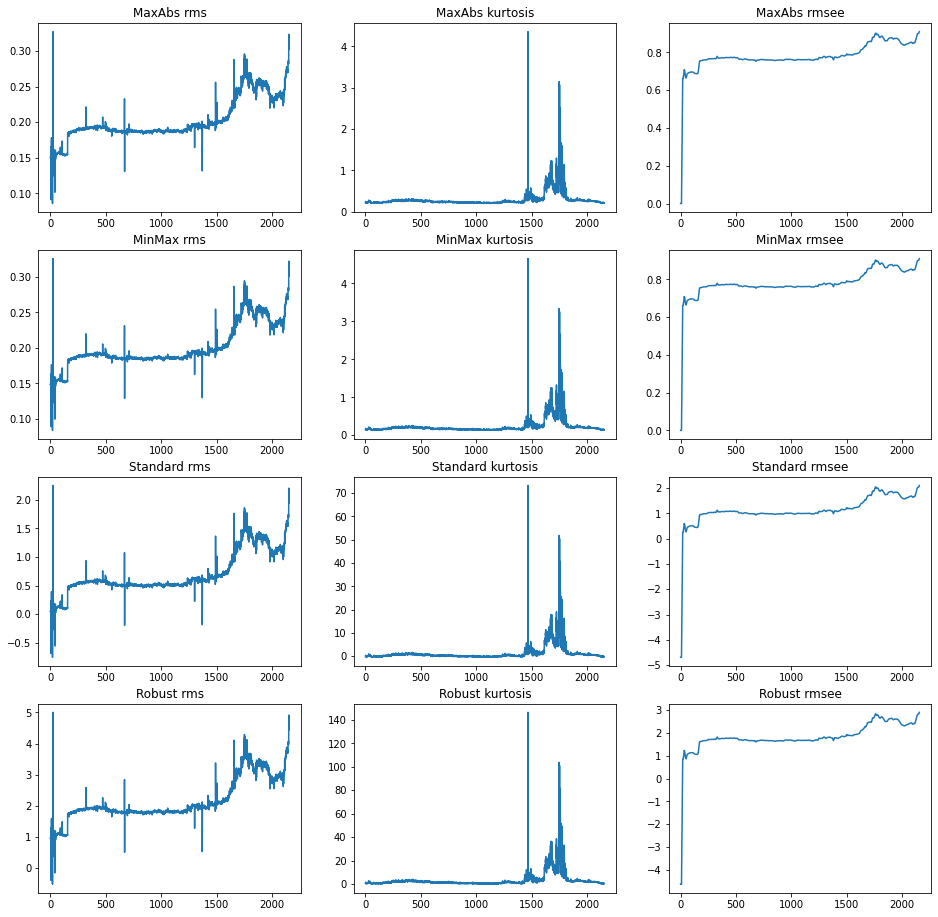

In [21]:
for scaler_key, scaler in keyed_scalers:
    for key in datas:
        apply_fit_normalization(datasets['test2'][key], scaler_key, datasets['train'][key])

fig, axs = plt.subplots(4, 3, figsize=((16, 16)))
for i in range(len(datas)):
    for j in range(len(scalers)):
        axs[j][i].plot(datasets['test2'][datas[i]][scalers[j]]['data'])
        axs[j][i].set_title(scalers[j] + ' ' + datas[i])

### Entre 0.0 e 1.0

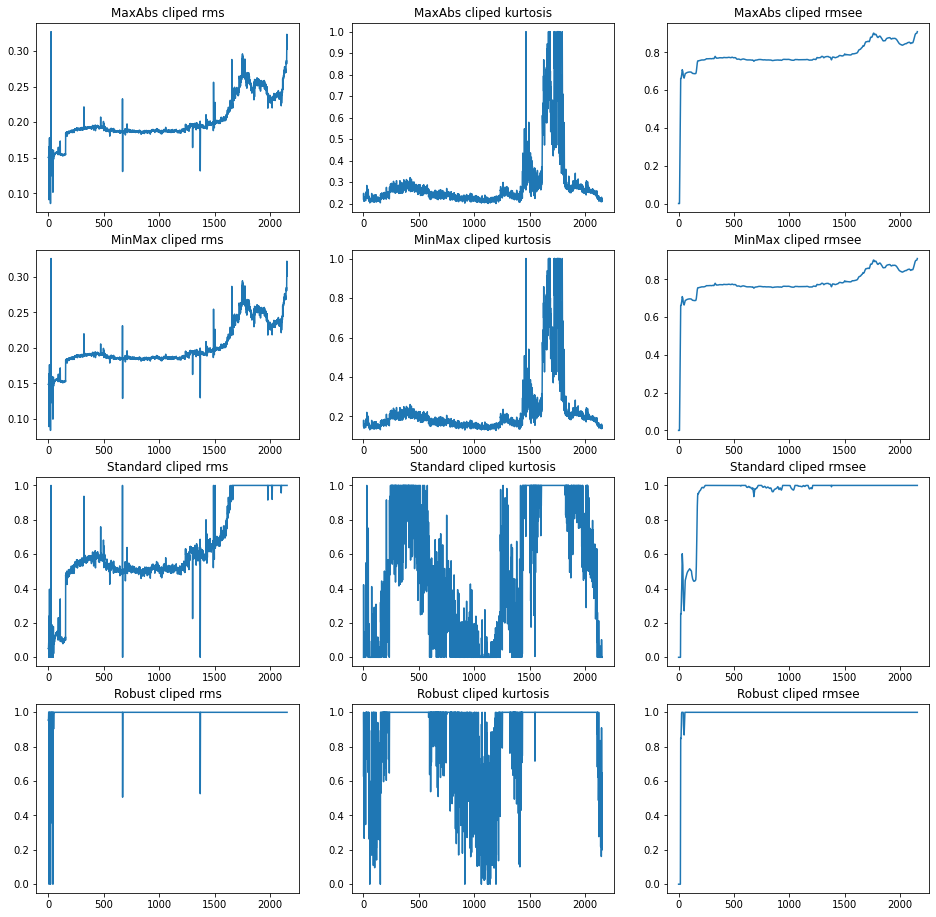

In [22]:
for scaler_key in scalers:
    for key in datas:
        datasets['test2'][key][scaler_key + '_Cliped'] = {}
        datasets['test2'][key][scaler_key + '_Cliped']['data'] = clip(datasets['test2'][key][scaler_key]['data'])
        
fig, axs = plt.subplots(4, 3, figsize=((16, 16)))
for i in range(len(datas)):
    for j in range(len(scalers)):
        axs[j][i].plot(datasets['test2'][datas[i]][scalers[j] + '_Cliped']['data'])
        axs[j][i].set_title(scalers[j] + ' cliped ' + datas[i])

# Treino

## SFAM - MaxAbs_Clipped

In [23]:
# import optuna

# def objective(trial):
#     alpha = trial.suggest_float("alpha", 1e-18, 1e+1, log=True)
#     rho = trial.suggest_float("rho", 1e-18, 1e+0, log=True)
#     beta = trial.suggest_float("beta", 1e-18, 1e+0, log=True)
#     epsilon = trial.suggest_float("epsilon", 1e-18, 1e+0, log=True)
#     uncommited_value = trial.suggest_float("uv", 1e-18, 1.0)
    
#     sfam = SFAM(alpha = alpha, rho = rho, beta = beta, epsilon = epsilon, uncommited_value = uncommited_value)
#     sfam.train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Cliped']['data'], 392)
#     return sfam.predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)
# print(study.best_trial.params)

# # #Trial 112 finished with value: 0.3947100712105799 and parameters: {'rho': 3.2358034120332154e-05, 'uv': 0.9835112751325361, 'alpha': 2.7270781618220184e-06}. Best is trial 112 with value: 0.3947100712105799.
# # #Trial 188 finished with value: 0.40183112919633773 and parameters: {'rho': 0.9295486941424583, 'uv': 0.984398658226122, 'alpha': 2.2668089565117578e-07, 'beta': 0.9426549691910234}. Best is trial 188 with value: 0.40183112919633773.
# # #Trial 108 finished with value: 0.427263479145473 and parameters: {'rho': 0.0009686028049355828, 'uv': 0.9883119821455072, 'alpha': 4.084979094859232e-07, 'beta': 6.613883552322061e-05}. Best is trial 108 with value: 0.427263479145473.
# # #Trial 871 finished with value: 0.427263479145473 and parameters: {'alpha': 1.1167576673504459e-08, 'rho': 0.0005592497019541445, 'beta': 0.005437777540556062, 'uv': 0.989645864609353}. Best is trial 871 with value: 0.427263479145473.
# # #Best is trial 241 with value: 0.42929806714140384. {'alpha': 3.395245641548146e-11, 'rho': 4.3521380132425176e-08, 'beta': 2.3557187791365324e-07, 'uv': 0.9885496137738817}
# # #Best is trial 890 with value: 0.6866734486266531. {'alpha': 0.08704579858923452, 'rho': 1.5842446614486082e-12, 'beta': 0.02433635084039448, 'uv': 0.9480472449474258}
# # #Best is trial 164 with value: 0.7293997965412004. {'alpha': 0.45977710064840743, 'rho': 4.592646278009706e-13, 'beta': 6.62470116222985e-11, 'uv': 6.140198929780164e-11}
# # # Best is trial 106 with value: 0.7426246185147508. {'alpha': 1.2517591322643648e-16, 'rho': 1.5164290602975099e-15, 'beta': 0.03496236267182363, 'uv': 0.5249178974615589}
# # sfam['MaxAbs'] = SFAM(alpha = 4.6715861565370895e-14, rho = 3.4726756552458553e-10, beta = 4.688230591139349e-17, uncommited_value = 0.9739101209573398)
# # {'alpha': 2.617325177043259e-06, 'rho': 7.679082091677435e-12, 'beta': 0.035495950650972226, 'uv': 0.6868487573343112}

In [24]:
sfam = {}

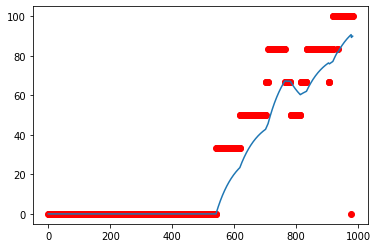

In [180]:
sfam['MaxAbs'] = SFAM(alpha = 3.3864038844388143e-06, rho = 3.657477124222113e-05, beta = 0.04844502173902665, epsilon = 0.23474188550938033, uncommited_value = 0.28034744230011377)

sfam['MaxAbs'].train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Cliped']['data'], 392)
sfam['MaxAbs'].predict_nasa(lambda x: datasets['train'][x]['MaxAbs']['data'], 392)
sfam['MaxAbs'].prune()

0.2259860788863109

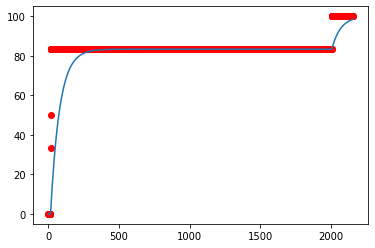

In [181]:
sfam['MaxAbs'].predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'])

0.20417633410672853

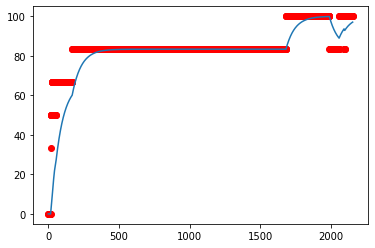

In [182]:
sfam['MaxAbs'].predict_nasa(lambda x: datasets['test2'][x]['MaxAbs_Cliped']['data'])

## MLP - MaxAbs_Clipped

In [27]:
# import optuna

# def objective(trial):

#     n_layers = trial.suggest_int('n_layers', 1, 6)
#     layers = []
#     for i in range(n_layers):
#         layers.append(trial.suggest_int(f'n_units_{i}', 1, 200))

#     activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
#     solver = trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam'])
#     alpha = trial.suggest_float("alpha", 1e-18, 1e+0, log=True)
    
#     if solver == 'sgd':
#         learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive'])
#         momentum = trial.suggest_float("momentum", 1e-18, 1e+0, log=True)
#     else:
#         learning_rate = 'constant'
#         momentum = 0.9
        
#     if solver == 'adam':
#         beta_1 = trial.suggest_float("beta_1", 1e-18, 1e+0, log=True)
#         beta_2 = trial.suggest_float("beta_2", 1e-18, 1e+0, log=True)
#     else:
#         beta_1 = 0.9
#         beta_2 = 0.999
    
    
#     clf = MLPClassifier(hidden_layer_sizes=tuple(layers), activation = activation, solver=solver, beta_1 = beta_1, beta_2 = beta_2, learning_rate = learning_rate, momentum = momentum, random_state = 0)
#     x_train, y_train = organize_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Cliped']['data'], 392)
#     x_val, y_val = organize_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'])
    
#     clf.fit(x_train, y_train)
#     return clf.score(x_val, y_val)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)
# print(study.best_trial.params)
# #Best is trial 141 with value: 0.7568667344862665. {'n_layers': 2, 'n_units_0': 1, 'n_units_1': 87, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 6.800537599344594e-16}

0.6541200406917599

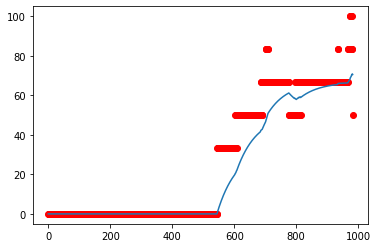

In [28]:
mlp = {}
mlp['MaxAbs'] = MLPClassifier(hidden_layer_sizes=(186, 42, 193, 189, 135, 145), activation = 'identity', solver='adam', alpha = 1.2049123869661849e-12, beta_1= 8.660310409635591e-05, beta_2= 0.013736105687331128, random_state = 0)

x_train, y_train = organize_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Cliped']['data'], 392)
x_val, y_val = organize_nasa(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392)
mlp['MaxAbs'].fit(x_train, y_train)

p = np.array(mlp['MaxAbs'].predict(x_val)) * (100.0 / 6.0)

plt.plot(p, 'ro')
plt.plot(smoothing(p))
mlp['MaxAbs'].score(x_val, y_val)

0.162877030162413

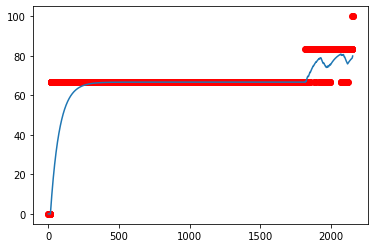

In [29]:
x_test, y_test = organize_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'])
p = np.array(mlp['MaxAbs'].predict(x_test)) * (100.0 / 6.0)

plt.plot(p, 'ro')
plt.plot(smoothing(p))
mlp['MaxAbs'].score(x_test, y_test)

## SFAM - MaxABs_Center

In [30]:
# import optuna

# def objective(trial):
#     alpha = trial.suggest_float("alpha", 1e-18, 1e+1, log=True)
#     rho = trial.suggest_float("rho", 1e-18, 1e+0, log=True)
#     beta = trial.suggest_float("beta", 1e-18, 1e+0, log=True)
#     uncommited_value = trial.suggest_float("uv", 0.5, 1e+0, log=True)
    
#     sfam = SFAM(alpha = alpha, rho = rho, beta = beta, uncommited_value = uncommited_value)
#     sfam.train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Center']['data'], 392)
#     return sfam.predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Center']['data'], 392, False)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=250)
# print(study.best_trial.params)
# # Best is trial 616 with value: 0.4008138351983723. {'alpha': 1.481329512950453e-10, 'rho': 3.693479376150351e-12, 'beta': 4.149916915933312e-09, 'uv': 0.9848333333556476}
# # Best is trial 466 with value: 0.7039674465920651. {'alpha': 5.622048313518151e-13, 'rho': 8.151965761257136e-09, 'beta': 5.763877184354314e-16, 'uv': 0.9924770110389107}


0.7375381485249237

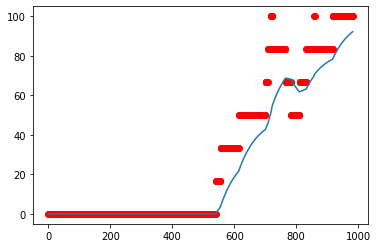

In [186]:
sfam['MaxAbs_Center'] = SFAM(alpha = 1.2932349835971422e-15, rho = 5.112297845240373e-12, beta = 0.036769828903903894, uncommited_value = 0.7552986535083299)

sfam['MaxAbs_Center'].train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Center']['data'], 392)
sfam['MaxAbs_Center'].predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Center']['data'], 392)

0.09976798143851508

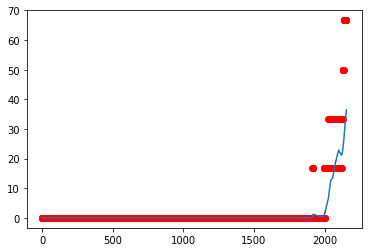

In [187]:
sfam['MaxAbs_Center'].predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Center']['data'])

## MLP - MaxAbs_Center

In [33]:
# import optuna

# def objective(trial):

#     n_layers = trial.suggest_int('n_layers', 1, 6)
#     layers = []
#     for i in range(n_layers):
#         layers.append(trial.suggest_int(f'n_units_{i}', 1, 200))

#     activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
#     solver = trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam'])
#     alpha = trial.suggest_float("alpha", 1e-18, 1e+0, log=True)
    
#     if solver == 'sgd':
#         learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive'])
#         momentum = trial.suggest_float("momentum", 1e-18, 1e+0, log=True)
#     else:
#         learning_rate = 'constant'
#         momentum = 0.9
        
#     if solver == 'adam':
#         beta_1 = trial.suggest_float("beta_1", 1e-18, 1e+0, log=True)
#         beta_2 = trial.suggest_float("beta_2", 1e-18, 1e+0, log=True)
#     else:
#         beta_1 = 0.9
#         beta_2 = 0.999
    
    
#     clf = MLPClassifier(hidden_layer_sizes=tuple(layers), activation = activation, solver=solver, beta_1 = beta_1, beta_2 = beta_2, learning_rate = learning_rate, momentum = momentum, random_state = 0)
#     x_train, y_train = organize_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Center']['data'], 392)
#     x_val, y_val = organize_nasa(lambda x: datasets['train'][x]['MaxAbs_Center']['data'], 392)
    
#     clf.fit(x_train, y_train)
#     return clf.score(x_val, y_val)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=200)
# print(study.best_trial.params)

# # #mlp['MaxAbs_Center'] = MLPClassifier(hidden_layer_sizes=(141, 84, 95, 22, 104), activation = 'relu', solver='adam')


0.6917599186164801

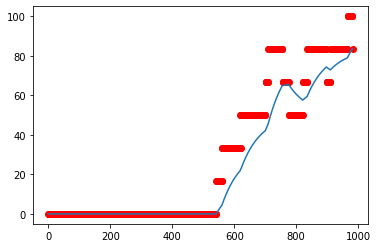

In [34]:
mlp = {}
mlp['MaxAbs_Center'] = MLPClassifier(hidden_layer_sizes=(110, 90, 92, 170, 66), activation = 'identity', solver='lbfgs', alpha = 7.793279570750885e-10, random_state = 0)

x_train, y_train = organize_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Center']['data'], 392)
x_val, y_val = organize_nasa(lambda x: datasets['train'][x]['MaxAbs_Center']['data'], 392)
mlp['MaxAbs_Center'].fit(x_train, y_train)

p = np.array(mlp['MaxAbs_Center'].predict(x_val)) * (100.0 / 6.0)

plt.plot(p, 'ro')
plt.plot(smoothing(p))
mlp['MaxAbs_Center'].score(x_val, y_val)

0.09976798143851508

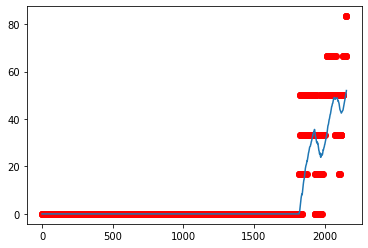

In [35]:
x_test, y_test = organize_nasa(lambda x: datasets['test'][x]['MaxAbs_Center']['data'])
p = np.array(mlp['MaxAbs_Center'].predict(x_test)) * (100.0 / 6.0)

plt.plot(p, 'ro')
plt.plot(smoothing(p))
mlp['MaxAbs_Center'].score(x_test, y_test)

## SFAM - MaxAbs_Zoom

In [36]:
# import optuna

# def objective(trial):
#     alpha = trial.suggest_float("alpha", 1e-18, 1e+1, log=True)
#     rho = trial.suggest_float("rho", 1e-18, 1e+0, log=True)
#     beta = trial.suggest_float("beta", 1e-18, 1e+0, log=True)
#     uncommited_value = trial.suggest_float("uv", 0.5, 1.0, log=True)
    
#     sfam = SFAM(alpha = alpha, rho = rho, beta = beta, uncommited_value = uncommited_value)
#     sfam.train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Zoom']['data'], 392)
#     return sfam.predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Zoom']['data'], 392)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)
# print(study.best_trial.params)

# # Best is trial 106 with value: 0.7426246185147508. {'alpha': 8.711044148724726e-15, 'rho': 1.651959726556269e-05, 'beta': 0.03556285811793728, 'uv': 0.622653730160301}
# # 0.7507629704984741 SFAM(alpha = 7.614130239297938e-16, rho = 0.0368073300339664, beta = 0.018306735816381994, uncommited_value = 0.860340588623127)

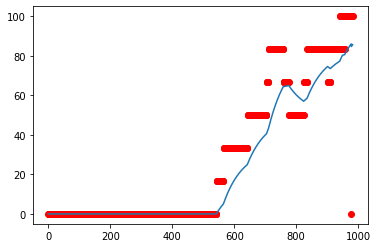

In [37]:
sfam['MaxAbs_Zoom'] = SFAM(alpha = 1.1661840026962726, rho = 2.7052884043004445e-05, beta = 0.8725909192315182, uncommited_value = 0.8909178357025973)

sfam['MaxAbs_Zoom'].train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Zoom']['data'], 392)
sfam['MaxAbs_Zoom'].predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Zoom']['data'], 392)
sfam['MaxAbs_Zoom'].prune()

0.1716937354988399

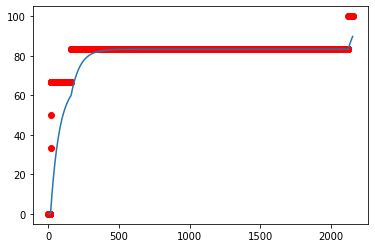

In [38]:
sfam['MaxAbs_Zoom'].predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Zoom']['data'])

## MLP - MaxAbs_Zoom

In [39]:
# import optuna

# def objective(trial):

#     n_layers = trial.suggest_int('n_layers', 1, 6)
#     layers = []
#     for i in range(n_layers):
#         layers.append(trial.suggest_int(f'n_units_{i}', 1, 200))

#     activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
#     solver = trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam'])
#     alpha = trial.suggest_float("alpha", 1e-18, 1e+0, log=True)
    
#     if solver == 'sgd':
#         learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive'])
#         momentum = trial.suggest_float("momentum", 1e-18, 1e+0, log=True)
#     else:
#         learning_rate = 'constant'
#         momentum = 0.9
        
#     if solver == 'adam':
#         beta_1 = trial.suggest_float("beta_1", 1e-18, 1e+0, log=True)
#         beta_2 = trial.suggest_float("beta_2", 1e-18, 1e+0, log=True)
#     else:
#         beta_1 = 0.9
#         beta_2 = 0.999
    
    
#     clf = MLPClassifier(hidden_layer_sizes=tuple(layers), activation = activation, solver=solver, beta_1 = beta_1, beta_2 = beta_2, learning_rate = learning_rate, momentum = momentum, random_state = 0)
#     x_train, y_train = organize_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Zoom']['data'], 392)
#     x_val, y_val = organize_nasa(lambda x: datasets['train'][x]['MaxAbs_Zoom']['data'], 392)
    
#     clf.fit(x_train, y_train)
#     return clf.score(x_val, y_val)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=200)
# print(study.best_trial.params)

# # #mlp['MaxAbs_Center'] = MLPClassifier(hidden_layer_sizes=(141, 84, 95, 22, 104), activation = 'relu', solver='adam')


c:\users\projeto\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7527975584944049

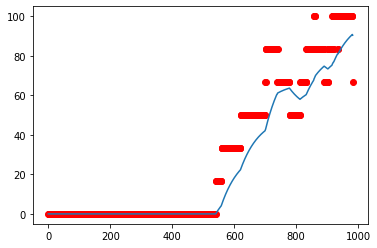

In [40]:
mlp['MaxAbs_Zoom'] = MLPClassifier(hidden_layer_sizes=(79, 124), activation = 'relu', solver='adam', alpha = 2.9734674750533706e-15, beta_1 = 2.092544907459088e-09, beta_2 = 0.4640112349610577, random_state = 0)

x_train, y_train = organize_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Zoom']['data'], 392)
x_val, y_val = organize_nasa(lambda x: datasets['train'][x]['MaxAbs_Zoom']['data'], 392)
mlp['MaxAbs_Zoom'].fit(x_train, y_train)

p = np.array(mlp['MaxAbs_Zoom'].predict(x_val)) * (100.0 / 6.0)

plt.plot(p, 'ro')
plt.plot(smoothing(p))
mlp['MaxAbs_Zoom'].score(x_val, y_val)

0.11276102088167053

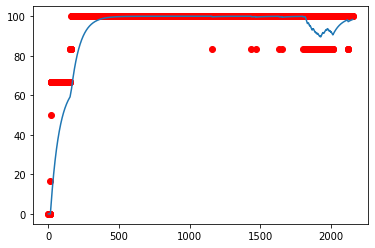

In [41]:
x_test, y_test = organize_nasa(lambda x: datasets['test'][x]['MaxAbs_Zoom']['data'])
p = np.array(mlp['MaxAbs_Zoom'].predict(x_test)) * (100.0 / 6.0)

plt.plot(p, 'ro')
plt.plot(smoothing(p))
mlp['MaxAbs_Zoom'].score(x_test, y_test)

# Treino variando ordem

## SFAM - MaxAbs_Cliped

In [42]:
# import optuna

# def objective(trial):
#     alpha = trial.suggest_float("alpha", 1e-18, 1e+1, log=True)
#     rho = trial.suggest_float("rho", 1e-18, 1e+0, log=True)
#     beta = trial.suggest_float("beta", 1e-18, 1e+0, log=True)
#     order = trial.suggest_int("order", 3, 25)
#     epsilon = trial.suggest_float("epsilon", 1e-18, 1e+0, log=True)
#     uncommited_value = trial.suggest_float("uv", 1e-18, 1.0)
    
#     sfam = SFAM(alpha = alpha, rho = rho, beta = beta, epsilon = epsilon, uncommited_value = uncommited_value)
#     sfam.train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Cliped']['data'], 392, order)
#     return sfam.predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392, order)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)
# print(study.best_trial.params)
# #Best is trial 56 with value: 0.7370030581039755. {'alpha': 1.901072353223224e-09, 'rho': 0.09435357495043345, 'beta': 0.04970296173592995, 'order': 4, 'uv': 0.8271269742914835}
# # order = 13
# # sfam['MaxAbs_HOrder'] = SFAM(input_size=order * 3, alpha = 1.4937614035813953e-05, rho = 0.001602074207017527, beta = 0.09486927599859632, uncommited_value = 0.6703351329846337)


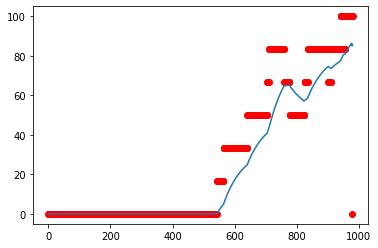

In [43]:
order = 4
sfam['MaxAbs_HOrder'] = SFAM(input_size=order * 3, alpha = 5.7178955012023405, rho = 0.1313726446633941, beta = 2.9058567705878517e-10, epsilon = 3.0314685749891967e-14, uncommited_value = 0.30476807052343236)

sfam['MaxAbs_HOrder'].train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Cliped']['data'], 392, order)
sfam['MaxAbs_HOrder'].predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392, order)
sfam['MaxAbs_HOrder'].prune()

0.1723176962378077

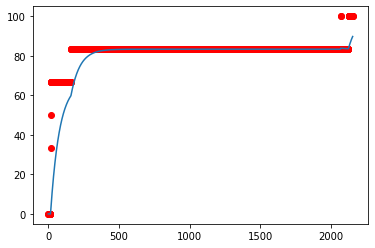

In [44]:
sfam['MaxAbs_HOrder'].predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'], -1, order)

## SFAM - MaxAbs_Center

In [45]:
# import optuna

# def objective(trial):
#     alpha = trial.suggest_float("alpha", 1e-18, 1e+1, log=True)
#     rho = trial.suggest_float("rho", 1e-18, 1e+0, log=True)
#     beta = trial.suggest_float("beta", 1e-18, 1e+0, log=True)
#     order = trial.suggest_int("order", 3, 25)
#     uncommited_value = trial.suggest_float("uv", 0.5, 1.0, log=True)
    
#     sfam = SFAM(input_size=3 * order, alpha = alpha, rho = rho, beta = beta, uncommited_value = uncommited_value)
#     sfam.train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Center']['data'], 392, order)
#     return sfam.predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Center']['data'], 392, order)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)
# print(study.best_trial.params)
# #Best is trial 89 with value: 0.7320328542094456. {'alpha': 3.664125890863213e-10, 'rho': 5.385562525240191e-13, 'beta': 0.06498813095645183, 'order': 11, 'uv': 0.7742260125177193}

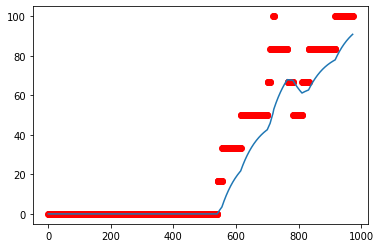

In [46]:
order = 11
sfam['MaxAbs_Center_HOrder'] = SFAM(input_size=order * 3, alpha = 3.664125890863213e-10, rho = 5.385562525240191e-13, beta = 0.06498813095645183, uncommited_value = 0.7742260125177193)

sfam['MaxAbs_Center_HOrder'].train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Center']['data'], 392, order)
sfam['MaxAbs_Center_HOrder'].predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Center']['data'], 392, order)
sfam['MaxAbs_Center_HOrder'].prune()

0.09599254426840634

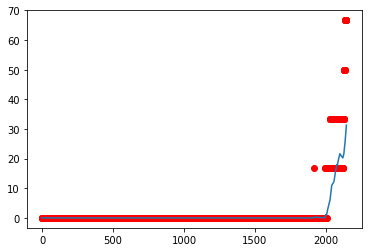

In [47]:
sfam['MaxAbs_Center_HOrder'].predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Center']['data'], -1, order)

## SFAM - MaxAbs_Zoom

In [48]:
# import optuna

# def objective(trial):
#     alpha = trial.suggest_float("alpha", 1e-18, 1e+1, log=True)
#     rho = trial.suggest_float("rho", 1e-18, 1e+0, log=True)
#     beta = trial.suggest_float("beta", 1e-18, 1e+0, log=True)
#     order = trial.suggest_int("order", 3, 25)
#     uncommited_value = trial.suggest_float("uv", 0.5, 1.0, log=True)
    
#     sfam = SFAM(input_size=3 * order, alpha = alpha, rho = rho, beta = beta, uncommited_value = uncommited_value)
#     sfam.train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Zoom']['data'], 392, order)
#     return sfam.predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Zoom']['data'], 392, order)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)
# print(study.best_trial.params)


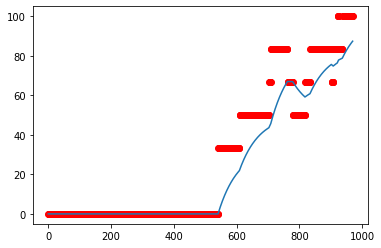

In [49]:
order = 14
sfam['MaxAbs_Zoom_HOrder'] = SFAM(input_size=order * 3, alpha = 0.49315860824457886, rho = 1.0329266002189683e-16, beta = 7.128032283404492e-14, uncommited_value = 0.5723724108474563)

sfam['MaxAbs_Zoom_HOrder'].train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Zoom']['data'], 392, order)
sfam['MaxAbs_Zoom_HOrder'].predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Zoom']['data'], 392, order)
sfam['MaxAbs_Zoom_HOrder'].prune()

0.21791880541297245

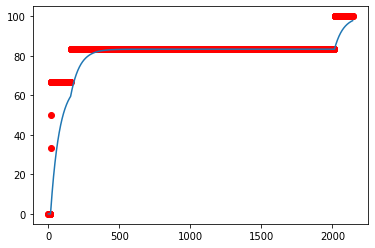

In [50]:
sfam['MaxAbs_Zoom_HOrder'].predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Zoom']['data'], -1, order)

In [51]:
# import optuna

# def objective(trial):
#     alpha = trial.suggest_float("alpha", 1e-18, 1e+1, log=True)
#     rho = trial.suggest_float("rho", 1e-18, 1e+0, log=True)
#     beta = trial.suggest_float("beta", 1e-18, 1e+0, log=True)
#     order = trial.suggest_int("order", 3, 25)
#     epsilon = trial.suggest_float("epsilon", 1e-18, 1e+0, log=True)
#     uncommited_value = trial.suggest_float("uv", 1e-18, 1.0)
    
#     sfam = SFAM(alpha = alpha, rho = rho, beta = beta, epsilon = epsilon, uncommited_value = uncommited_value)
#     sfam.train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Cliped']['data'], 392, order)
#     return sfam.predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'], -1, order)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)
# print(study.best_trial.params)


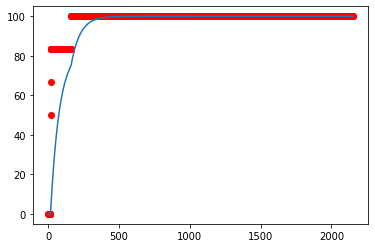

In [52]:
order = 6
sfam['MaxAbs_Zoom_HOrder'] = SFAM(input_size=order * 3, alpha = 1.706915146560203e-11, rho = 1.9858072835258157e-15, beta = 6.885308818236919e-13, epsilon = 6.226374702800287e-13, uncommited_value = 0.4122217880215322)

sfam['MaxAbs_Zoom_HOrder'].train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Cliped']['data'], 392, order)
sfam['MaxAbs_Zoom_HOrder'].predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'], -1, order)
sfam['MaxAbs_Zoom_HOrder'].prune()

In [53]:
# import optuna

# def objective(trial):
#     alpha = trial.suggest_float("alpha", 1e-18, 1e+1, log=True)
#     rho = trial.suggest_float("rho", 1e-18, 1e+0, log=True)
#     beta = trial.suggest_float("beta", 1e-18, 1e+0, log=True)
#     order = trial.suggest_int("order", 3, 25)
#     uncommited_value = trial.suggest_float("uv", 0.5, 1.0, log=True)
    
#     sfam = SFAM(input_size=3 * order, alpha = alpha, rho = rho, beta = beta, uncommited_value = uncommited_value)
#     sfam.train_nasa(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392, order)
#     return sfam.predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'], -1, order)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)
# print(study.best_trial.params)


In [54]:
# import optuna

# def objective(trial):

#     n_layers = trial.suggest_int('n_layers', 1, 6)
#     layers = []
#     for i in range(n_layers):
#         layers.append(trial.suggest_int(f'n_units_{i}', 1, 200))

#     activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
#     solver = trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam'])
#     alpha = trial.suggest_float("alpha", 1e-18, 1e+0, log=True)
    
#     if solver == 'sgd':
#         learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive'])
#         momentum = trial.suggest_float("momentum", 1e-18, 1e+0, log=True)
#     else:
#         learning_rate = 'constant'
#         momentum = 0.9
        
#     if solver == 'adam':
#         beta_1 = trial.suggest_float("beta_1", 1e-18, 1e+0, log=True)
#         beta_2 = trial.suggest_float("beta_2", 1e-18, 1e+0, log=True)
#     else:
#         beta_1 = 0.9
#         beta_2 = 0.999
    
#     order = trial.suggest_int("order", 3, 25)
    
#     clf = MLPClassifier(hidden_layer_sizes=tuple(layers), activation = activation, solver=solver, beta_1 = beta_1, beta_2 = beta_2, learning_rate = learning_rate, momentum = momentum, random_state = 0)
#     x_train, y_train = organize_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Zoom']['data'], 392, order)
#     x_val, y_val = organize_nasa(lambda x: datasets['train'][x]['MaxAbs_Zoom']['data'], 392, order)
    
#     clf.fit(x_train, y_train)
#     return clf.score(x_val, y_val)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)
# print(study.best_trial.params)

# # #mlp['MaxAbs_Center'] = MLPClassifier(hidden_layer_sizes=(141, 84, 95, 22, 104), activation = 'relu', solver='adam')


# Shuffle_train

## Sem order

### Com ufrf

[I 2021-11-08 23:34:41,373] A new study created in memory with name: no-name-cd6a4b77-7b06-4c14-8237-01009b5befb6
[I 2021-11-08 23:34:41,865] Trial 0 finished with value: 0.7019328585961343 and parameters: {'alpha': 4.589732657657255e-09, 'rho': 0.018683757110584804, 'beta': 0.6684499075606307, 'epsilon': 0.0027124263719355405, 'uv': 0.9583697338609903}. Best is trial 0 with value: 0.7019328585961343.
[I 2021-11-08 23:34:52,373] Trial 1 finished with value: 0.6968463886063072 and parameters: {'alpha': 3045489.269397947, 'rho': 2.3195955972436446e-05, 'beta': 0.5219993719397313, 'epsilon': 1.6359264642099875e-06, 'uv': 0.4176843323396159}. Best is trial 0 with value: 0.7019328585961343.
[I 2021-11-08 23:35:03,047] Trial 2 finished with value: 0.6968463886063072 and parameters: {'alpha': 351299854560.83154, 'rho': 5.076729195984112e-07, 'beta': 0.8751816396647627, 'epsilon': 7.838682930127726e-07, 'uv': 0.05192346178343116}. Best is trial 0 with value: 0.7019328585961343.
[I 2021-11-08 2

[I 2021-11-08 23:36:34,774] Trial 27 finished with value: 0.6958290946083419 and parameters: {'alpha': 0.0783758972521729, 'rho': 3.732862530452122e-06, 'beta': 0.5734882881733903, 'epsilon': 5.568882955035736e-09, 'uv': 0.4522003023255051}. Best is trial 18 with value: 0.7080366225839267.
[I 2021-11-08 23:36:45,035] Trial 28 finished with value: 0.6968463886063072 and parameters: {'alpha': 6.974141309222009, 'rho': 1.977110966997252e-09, 'beta': 0.5011743240030258, 'epsilon': 5.271349299643314e-06, 'uv': 0.2944915729984129}. Best is trial 18 with value: 0.7080366225839267.
[I 2021-11-08 23:36:45,356] Trial 29 finished with value: 0.7039674465920651 and parameters: {'alpha': 9.722647508901318e-09, 'rho': 1.5860186836209298e-10, 'beta': 0.6259013162108114, 'epsilon': 0.0012034688775842026, 'uv': 0.7106463427892693}. Best is trial 18 with value: 0.7080366225839267.


{'alpha': 1.8816157592091586e-08, 'rho': 1.8617039027712794e-08, 'beta': 0.5004790482050023, 'epsilon': 2.2637857050173263e-05, 'uv': 0.6723310783439534}


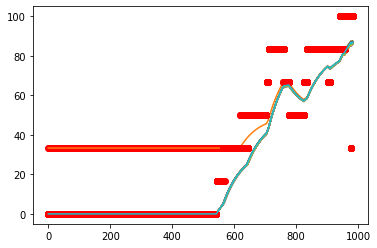

In [99]:
import optuna

def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-10, 1e+12, log=True)
    rho = trial.suggest_float("rho", 1e-10, 1e+0, log=True)
    beta = trial.suggest_float("beta", 0.5, 1e+0, log=True)
    epsilon = trial.suggest_float("epsilon", 1e-10, 1e+0, log=True)
    uncommited_value = trial.suggest_float("uv", 0.001, 1e+0)
    
    sfam = SFAM(alpha = alpha, rho = rho, beta = beta, epsilon = epsilon, uncommited_value = uncommited_value)
    sfam.shuffle_nasa_train(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Cliped']['data'], 392)
    return sfam.predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print(study.best_trial.params)

# sfam['MaxAbs_Shuffle'] = SFAM(alpha = 0.011518807525753528, rho = 8.515579176690106e-09, beta = 0.006392025284083809, epsilon = 3.374690966331042e-06, uncommited_value = 0.4331646065996603)

#### Train

0.7080366225839267

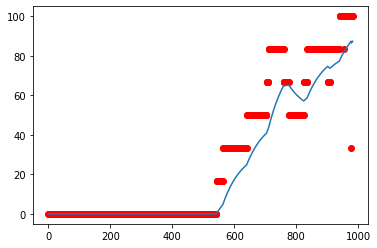

In [149]:
# sfam['MaxAbs_Shuffle'] = SFAM(alpha = 0.08561132960605239, rho = 0.016531520983938345, beta = 0.713474522053423, epsilon = 0.021119268522436573, uncommited_value = 0.8625161376591538)

sfam['MaxAbs_Shuffle'] = SFAM(alpha = 1.8816157592091586e-08, rho = 1.8617039027712794e-08, beta = 0.5004790482050023, epsilon = 2.2637857050173263e-05, uncommited_value = 0.6723310783439534)

sfam['MaxAbs_Shuffle'].shuffle_nasa_train(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Cliped']['data'], 392)
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392)

#### Test

0.1791183294663573

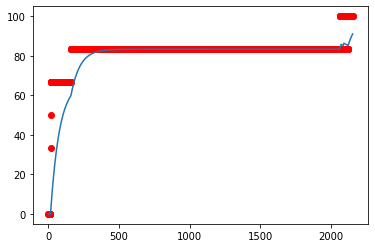

In [150]:
sfam['MaxAbs_Shuffle'].prune()
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'])

#### Test2

0.1814385150812065

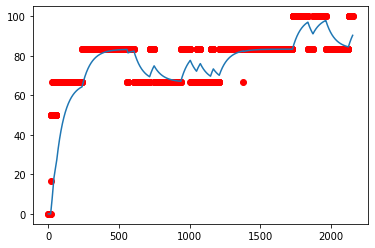

In [151]:
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['test2'][x]['MaxAbs_Cliped']['data'])

### Sem ufrf

[I 2021-11-08 23:36:45,518] A new study created in memory with name: no-name-b5ae0a91-b11c-4246-9352-ca06e421b6ab
[I 2021-11-08 23:36:55,419] Trial 0 finished with value: 0.9989827060020345 and parameters: {'alpha': 574613.1582716915, 'rho': 0.06582664439658847, 'beta': 0.9588551126247702, 'epsilon': 0.583275640426613, 'uv': 0.06723002127854139}. Best is trial 0 with value: 0.9989827060020345.
[I 2021-11-08 23:37:05,825] Trial 1 finished with value: 0.9989827060020345 and parameters: {'alpha': 0.4781844328765996, 'rho': 1.1661541417112704e-07, 'beta': 0.7494587853478842, 'epsilon': 4.417856850454823e-05, 'uv': 0.7003910518837747}. Best is trial 0 with value: 0.9989827060020345.
[I 2021-11-08 23:37:16,619] Trial 2 finished with value: 0.9989827060020345 and parameters: {'alpha': 1.6987349219075643, 'rho': 2.807026969135073e-06, 'beta': 0.7428442213035841, 'epsilon': 1.4677092383983625e-08, 'uv': 0.8219760085245201}. Best is trial 0 with value: 0.9989827060020345.
[I 2021-11-08 23:37:21,

[I 2021-11-08 23:41:01,109] Trial 27 finished with value: 0.9989827060020345 and parameters: {'alpha': 362771417.7848488, 'rho': 0.0031172094508864936, 'beta': 0.6271171101875879, 'epsilon': 0.0008055141504315078, 'uv': 0.005581524138863356}. Best is trial 0 with value: 0.9989827060020345.
[I 2021-11-08 23:41:12,075] Trial 28 finished with value: 0.9989827060020345 and parameters: {'alpha': 56455136.80061505, 'rho': 0.09520671437538894, 'beta': 0.5677634233936385, 'epsilon': 0.3393749003529967, 'uv': 0.11114446160935462}. Best is trial 0 with value: 0.9989827060020345.
[I 2021-11-08 23:41:22,897] Trial 29 finished with value: 0.9989827060020345 and parameters: {'alpha': 304000.6554672296, 'rho': 0.03444137845497927, 'beta': 0.7589246008880566, 'epsilon': 0.026203418506489634, 'uv': 0.0772216697281762}. Best is trial 0 with value: 0.9989827060020345.


{'alpha': 574613.1582716915, 'rho': 0.06582664439658847, 'beta': 0.9588551126247702, 'epsilon': 0.583275640426613, 'uv': 0.06723002127854139}


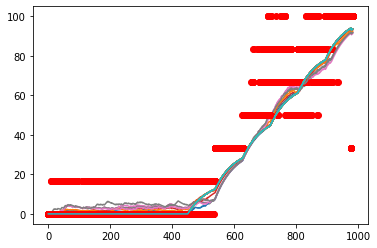

In [100]:
import optuna

def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-10, 1e+12, log=True)
    rho = trial.suggest_float("rho", 1e-10, 1e+0, log=True)
    beta = trial.suggest_float("beta", 0.5, 1e+0, log=True)
    epsilon = trial.suggest_float("epsilon", 1e-10, 1e+0, log=True)
    uncommited_value = trial.suggest_float("uv", 0.001, 1e+0)
    
    sfam = SFAM(alpha = alpha, rho = rho, beta = beta, epsilon = epsilon, uncommited_value = uncommited_value)
    sfam.shuffle_nasa_train(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392)
    return sfam.predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print(study.best_trial.params)

# sfam['MaxAbs_Shuffle'] = SFAM(alpha = 0.011518807525753528, rho = 8.515579176690106e-09, beta = 0.006392025284083809, epsilon = 3.374690966331042e-06, uncommited_value = 0.4331646065996603)

#### Train

0.9989827060020345

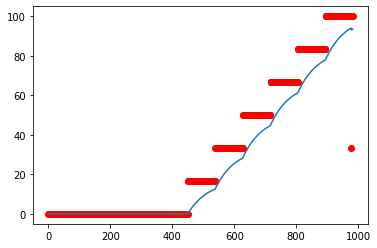

In [152]:
# sfam['MaxAbs_Shuffle'] = SFAM(alpha = 0.011518807525753528, rho = 8.515579176690106e-09, beta = 0.006392025284083809, epsilon = 3.374690966331042e-06, uncommited_value = 0.4331646065996603)

sfam['MaxAbs_Shuffle'] = SFAM(alpha = 574613.1582716915, rho = 0.06582664439658847, beta = 0.9588551126247702, epsilon = 0.583275640426613, uncommited_value = 0.06723002127854139)

sfam['MaxAbs_Shuffle'].shuffle_nasa_train(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392)
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392)

#### Test

0.20696055684454756

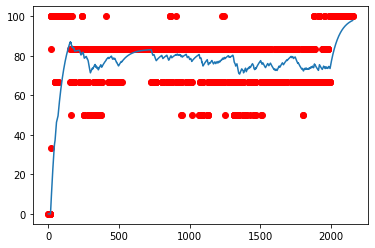

In [153]:
sfam['MaxAbs_Shuffle'].prune()
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'])

#### Test2

0.24269141531322505

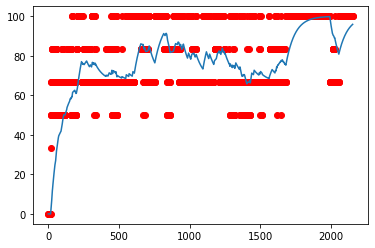

In [154]:
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['test2'][x]['MaxAbs_Cliped']['data'])

### No teste com ufrf

[I 2021-11-08 23:41:23,063] A new study created in memory with name: no-name-c8d493e6-59c9-4a6b-8c59-22573687360b
[I 2021-11-08 23:41:42,928] Trial 0 finished with value: 0.1716937354988399 and parameters: {'alpha': 183086987.62512863, 'rho': 3.788626641318896e-05, 'beta': 0.5140923650240685, 'epsilon': 4.53154460447576e-10, 'uv': 0.04813060592902943}. Best is trial 0 with value: 0.1716937354988399.
[I 2021-11-08 23:41:43,514] Trial 1 finished with value: 0.17215777262180976 and parameters: {'alpha': 7.483936769660022e-07, 'rho': 0.005590577580260069, 'beta': 0.7063272786410735, 'epsilon': 0.0014019720103719605, 'uv': 0.658548222993999}. Best is trial 1 with value: 0.17215777262180976.
[I 2021-11-08 23:42:02,890] Trial 2 finished with value: 0.1716937354988399 and parameters: {'alpha': 610.2103600170138, 'rho': 0.00010437580409550766, 'beta': 0.5297755485738608, 'epsilon': 0.00031583871731529845, 'uv': 0.255661280519702}. Best is trial 1 with value: 0.17215777262180976.
[I 2021-11-08 2

[I 2021-11-08 23:43:58,247] Trial 27 finished with value: 0.1642691415313225 and parameters: {'alpha': 1.2379690730255103e-06, 'rho': 6.649990189209444e-06, 'beta': 0.5271571094418388, 'epsilon': 0.7472975620989698, 'uv': 0.48395407278792824}. Best is trial 23 with value: 0.1791183294663573.
[I 2021-11-08 23:44:18,190] Trial 28 finished with value: 0.1716937354988399 and parameters: {'alpha': 158.1065195641602, 'rho': 1.6479524376031003e-07, 'beta': 0.5063449654826123, 'epsilon': 0.009203404403336769, 'uv': 0.3415630123082175}. Best is trial 23 with value: 0.1791183294663573.
[I 2021-11-08 23:44:18,696] Trial 29 finished with value: 0.1777262180974478 and parameters: {'alpha': 3.471858103225692e-08, 'rho': 1.2920361905281752e-05, 'beta': 0.5231995097814652, 'epsilon': 0.00043607622214733165, 'uv': 0.5987044666351959}. Best is trial 23 with value: 0.1791183294663573.


{'alpha': 3.1939107658466404e-05, 'rho': 1.4421999746657232e-07, 'beta': 0.502077534680409, 'epsilon': 0.053559564843432994, 'uv': 0.3820435792972554}


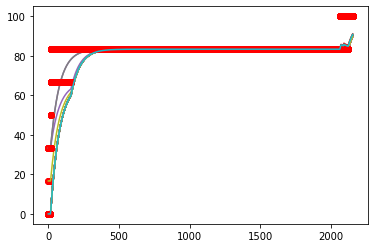

In [101]:
import optuna

def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-10, 1e+12, log=True)
    rho = trial.suggest_float("rho", 1e-10, 1e+0, log=True)
    beta = trial.suggest_float("beta", 0.5, 1e+0, log=True)
    epsilon = trial.suggest_float("epsilon", 1e-10, 1e+0, log=True)
    uncommited_value = trial.suggest_float("uv", 0.001, 1e+0)
    
    sfam = SFAM(alpha = alpha, rho = rho, beta = beta, epsilon = epsilon, uncommited_value = uncommited_value)
    sfam.shuffle_nasa_train(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Cliped']['data'], 392)
    return sfam.predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'])

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print(study.best_trial.params)

# sfam['MaxAbs_Shuffle'] = SFAM(alpha = 0.011518807525753528, rho = 8.515579176690106e-09, beta = 0.006392025284083809, epsilon = 3.374690966331042e-06, uncommited_value = 0.4331646065996603)

#### Train

0.1791183294663573

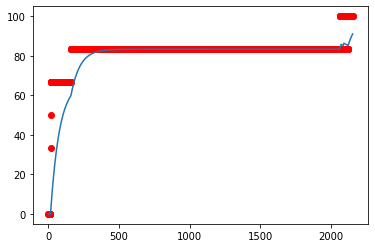

In [155]:
sfam['MaxAbs_Shuffle'] = SFAM(alpha = 3.1939107658466404e-05, rho = 1.4421999746657232e-07, beta = 0.502077534680409, epsilon = 0.053559564843432994, uncommited_value = 0.3820435792972554)

sfam['MaxAbs_Shuffle'].shuffle_nasa_train(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Cliped']['data'], 392)
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'])

#### Test - Train

0.7070193285859614

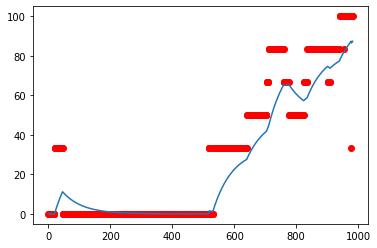

In [129]:
sfam['MaxAbs_Shuffle'].prune()
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392)

#### Test2

0.1814385150812065

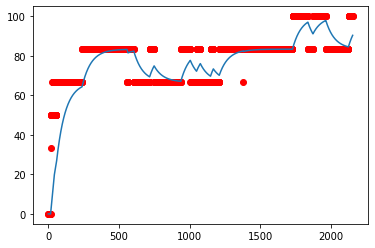

In [116]:
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['test2'][x]['MaxAbs_Cliped']['data'])

### No teste sem ufrf

[I 2021-11-09 00:35:01,927] A new study created in memory with name: no-name-0dc5ce05-a069-4969-91c3-9903b3b00f11
[I 2021-11-09 00:35:21,705] Trial 0 finished with value: 0.20696055684454756 and parameters: {'alpha': 1429606965.2491443, 'rho': 0.24819336754953694, 'beta': 0.9149778953003654, 'epsilon': 6.088393639741318e-05, 'uv': 0.9411961521814668}. Best is trial 0 with value: 0.20696055684454756.
[I 2021-11-09 00:35:25,024] Trial 1 finished with value: 0.18932714617169374 and parameters: {'alpha': 4.346668692252347e-06, 'rho': 2.620563710824347e-07, 'beta': 0.8324508247190238, 'epsilon': 0.00010677403849440381, 'uv': 0.2361621865447772}. Best is trial 0 with value: 0.20696055684454756.
[I 2021-11-09 00:35:45,005] Trial 2 finished with value: 0.20696055684454756 and parameters: {'alpha': 2371304.8026214456, 'rho': 1.7159971714603018e-06, 'beta': 0.7210310683290824, 'epsilon': 0.0002973682067175004, 'uv': 0.6085115987389114}. Best is trial 0 with value: 0.20696055684454756.
[I 2021-11

[I 2021-11-09 00:38:57,802] Trial 27 finished with value: 0.2756380510440835 and parameters: {'alpha': 0.00018242013327483957, 'rho': 1.1173132600455923e-10, 'beta': 0.6802725538354082, 'epsilon': 5.172960281049986e-08, 'uv': 0.9956158474013833}. Best is trial 10 with value: 0.2904872389791183.
[I 2021-11-09 00:39:06,016] Trial 28 finished with value: 0.23062645011600927 and parameters: {'alpha': 0.15255458625009563, 'rho': 2.51459318372545e-07, 'beta': 0.6113340732930672, 'epsilon': 0.0018190071807324087, 'uv': 0.6504944742958607}. Best is trial 10 with value: 0.2904872389791183.
[I 2021-11-09 00:39:10,241] Trial 29 finished with value: 0.2677494199535963 and parameters: {'alpha': 0.0009747352836324428, 'rho': 0.23354564754944004, 'beta': 0.7661828495365328, 'epsilon': 0.17319642649782713, 'uv': 0.9223716721982946}. Best is trial 10 with value: 0.2904872389791183.


{'alpha': 2.980088610848902e-09, 'rho': 2.39144697622943e-10, 'beta': 0.5078115199710304, 'epsilon': 0.7372350083061249, 'uv': 0.8923221469596608}


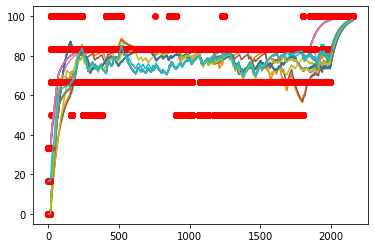

In [122]:
import optuna

def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-10, 1e+12, log=True)
    rho = trial.suggest_float("rho", 1e-10, 1e+0, log=True)
    beta = trial.suggest_float("beta", 0.5, 1e+0, log=True)
    epsilon = trial.suggest_float("epsilon", 1e-10, 1e+0, log=True)
    uncommited_value = trial.suggest_float("uv", 0.001, 1e+0)
    
    sfam = SFAM(alpha = alpha, rho = rho, beta = beta, epsilon = epsilon, uncommited_value = uncommited_value)
    sfam.shuffle_nasa_train(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392)
    return sfam.predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'])

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print(study.best_trial.params)

# sfam['MaxAbs_Shuffle'] = SFAM(alpha = 0.011518807525753528, rho = 8.515579176690106e-09, beta = 0.006392025284083809, epsilon = 3.374690966331042e-06, uncommited_value = 0.4331646065996603)

#### Train

0.2904872389791183

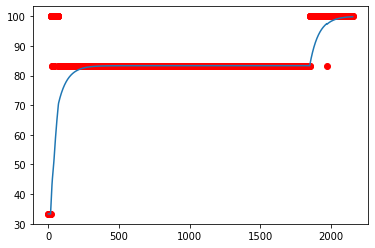

In [156]:
sfam['MaxAbs_Shuffle'] = SFAM(alpha = 2.980088610848902e-09, rho = 2.39144697622943e-10, beta = 0.5078115199710304, epsilon = 0.7372350083061249, uncommited_value = 0.8923221469596608)

sfam['MaxAbs_Shuffle'].shuffle_nasa_train(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392)
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'])

#### Test - Train

0.15462868769074262

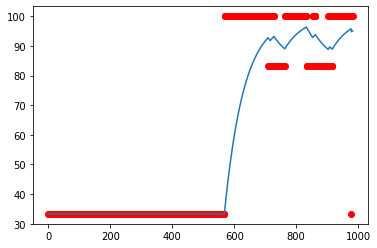

In [157]:
sfam['MaxAbs_Shuffle'].prune()
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392)

#### Test2

0.2273781902552204

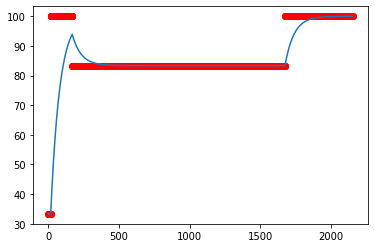

In [158]:
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['test2'][x]['MaxAbs_Cliped']['data'])

## Com order

### Com ufrf

[I 2021-11-08 23:44:18,900] A new study created in memory with name: no-name-8f1b8014-413a-4302-a649-ae3d60da2196
[I 2021-11-08 23:44:19,084] Trial 0 finished with value: 0.39094650205761317 and parameters: {'alpha': 2.581827869387152e-06, 'rho': 0.002641544797183809, 'beta': 0.7738130252060091, 'epsilon': 0.0001823361720804012, 'uv': 0.3353797377963068, 'order': 13}. Best is trial 0 with value: 0.39094650205761317.
[I 2021-11-08 23:44:19,440] Trial 1 finished with value: 0.46098562628336753 and parameters: {'alpha': 0.007013933265789246, 'rho': 0.00728194253270336, 'beta': 0.6633184993805289, 'epsilon': 0.18110062803112154, 'uv': 0.2812610404938226, 'order': 11}. Best is trial 1 with value: 0.46098562628336753.
[I 2021-11-08 23:44:19,640] Trial 2 finished with value: 0.4605128205128205 and parameters: {'alpha': 1.089283737122145e-06, 'rho': 2.417221908164538e-09, 'beta': 0.6523900954861825, 'epsilon': 1.8609175892346807e-09, 'uv': 0.896649160128163, 'order': 10}. Best is trial 1 with 

[I 2021-11-08 23:47:46,251] Trial 26 finished with value: 0.4439918533604888 and parameters: {'alpha': 888361952864.9287, 'rho': 7.392872046163337e-06, 'beta': 0.5008227641313815, 'epsilon': 1.82450287596303e-08, 'uv': 0.7258938406417362, 'order': 3}. Best is trial 25 with value: 0.6931702344546381.
[I 2021-11-08 23:47:56,828] Trial 27 finished with value: 0.4610655737704918 and parameters: {'alpha': 1373022099.5243835, 'rho': 8.056704897144313e-08, 'beta': 0.58205594164914, 'epsilon': 1.0291013048142266e-06, 'uv': 0.8530457926147094, 'order': 9}. Best is trial 25 with value: 0.6931702344546381.
[I 2021-11-08 23:48:07,258] Trial 28 finished with value: 0.6931702344546381 and parameters: {'alpha': 78092.39449350846, 'rho': 0.0014887612124129845, 'beta': 0.5440723503251719, 'epsilon': 7.627180071881307e-07, 'uv': 0.4069225484891158, 'order': 4}. Best is trial 25 with value: 0.6931702344546381.
[I 2021-11-08 23:48:17,575] Trial 29 finished with value: 0.38786008230452673 and parameters: {

{'alpha': 469485651.63208663, 'rho': 2.6688818345839734e-05, 'beta': 0.5900653734072322, 'epsilon': 1.0428311616811367e-08, 'uv': 0.6765298014258014, 'order': 4}


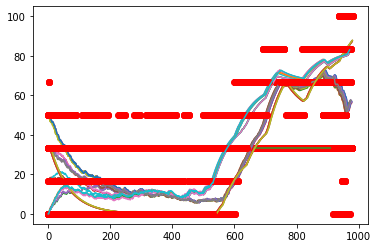

In [102]:
import optuna

def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-10, 1e+12, log=True)
    rho = trial.suggest_float("rho", 1e-10, 1e+0, log=True)
    beta = trial.suggest_float("beta", 0.5, 1e+0, log=True)
    epsilon = trial.suggest_float("epsilon", 1e-10, 1e+0, log=True)
    uncommited_value = trial.suggest_float("uv", 0.001, 1e+0)
    order = trial.suggest_int("order", 3, 20)
    
    sfam = SFAM(alpha = alpha, rho = rho, beta = beta, epsilon = epsilon, uncommited_value = uncommited_value)
    sfam.shuffle_nasa_train(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Cliped']['data'], 392, order)
    return sfam.predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392, order)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print(study.best_trial.params)

# sfam['MaxAbs_Shuffle'] = SFAM(alpha = 0.011518807525753528, rho = 8.515579176690106e-09, beta = 0.006392025284083809, epsilon = 3.374690966331042e-06, uncommited_value = 0.4331646065996603)

#### Train

0.6931702344546381

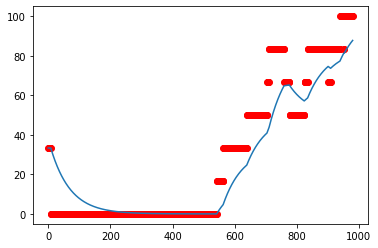

In [159]:
# sfam['MaxAbs_Shuffle'] = SFAM(alpha = 1.6567020207018912, rho = 0.037607532992751984, beta = 0.7324093401615666, epsilon = 0.0007816538021598521, uncommited_value = 0.8279089243935547)
order = 4
sfam['MaxAbs_Shuffle'] = SFAM(alpha = 469485651.63208663, rho = 2.6688818345839734e-05, beta = 0.5900653734072322, epsilon = 1.0428311616811367e-08, uncommited_value = 0.6765298014258014)

sfam['MaxAbs_Shuffle'].shuffle_nasa_train(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Cliped']['data'], 392, order)
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392, order)

#### Test

0.17138875986994892

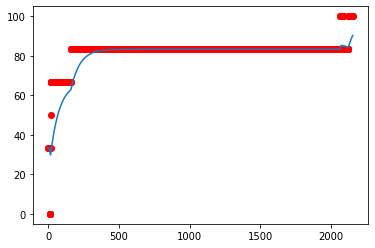

In [160]:
sfam['MaxAbs_Shuffle'].prune()
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'], -1, order)

#### Test2

0.1778913144449605

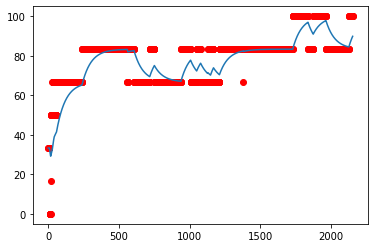

In [161]:
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['test2'][x]['MaxAbs_Cliped']['data'], -1, order)

### Sem ufrf

[I 2021-11-08 23:54:03,084] A new study created in memory with name: no-name-7ab8a922-aa77-4057-b417-2876cbd6b5a5
[I 2021-11-08 23:54:14,064] Trial 0 finished with value: 0.9938775510204082 and parameters: {'alpha': 139630616.5600104, 'rho': 5.732351327730019e-05, 'beta': 0.7105472924048373, 'epsilon': 5.075508762173707e-09, 'uv': 0.7434464826220165, 'order': 5}. Best is trial 0 with value: 0.9938775510204082.
[I 2021-11-08 23:54:25,967] Trial 1 finished with value: 1.0 and parameters: {'alpha': 776290.5535842044, 'rho': 0.0008149210583998265, 'beta': 0.5504618504091746, 'epsilon': 4.898721222384571e-07, 'uv': 0.2670182720631446, 'order': 17}. Best is trial 1 with value: 1.0.
[I 2021-11-08 23:54:38,636] Trial 2 finished with value: 0.9938398357289527 and parameters: {'alpha': 8813083508.393673, 'rho': 6.983254303719971e-10, 'beta': 0.7199994283286736, 'epsilon': 5.527327983438253e-07, 'uv': 0.15958972713995281, 'order': 11}. Best is trial 1 with value: 1.0.
[I 2021-11-08 23:54:40,369] 

[I 2021-11-08 23:58:19,995] Trial 28 finished with value: 0.17922606924643583 and parameters: {'alpha': 0.06239381620157433, 'rho': 0.1820792126158806, 'beta': 0.6696271336168248, 'epsilon': 0.00012868372762553707, 'uv': 0.8006493337526936, 'order': 3}. Best is trial 1 with value: 1.0.
[I 2021-11-08 23:58:29,438] Trial 29 finished with value: 1.0 and parameters: {'alpha': 38.68102553146738, 'rho': 0.00011694332735233057, 'beta': 0.6836332497104429, 'epsilon': 7.279492272672881e-08, 'uv': 0.6875586323685918, 'order': 18}. Best is trial 1 with value: 1.0.


{'alpha': 776290.5535842044, 'rho': 0.0008149210583998265, 'beta': 0.5504618504091746, 'epsilon': 4.898721222384571e-07, 'uv': 0.2670182720631446, 'order': 17}


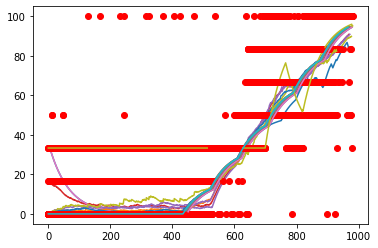

In [105]:
import optuna

def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-10, 1e+12, log=True)
    rho = trial.suggest_float("rho", 1e-10, 1e+0, log=True)
    beta = trial.suggest_float("beta", 0.5, 1e+0, log=True)
    epsilon = trial.suggest_float("epsilon", 1e-10, 1e+0, log=True)
    uncommited_value = trial.suggest_float("uv", 0.001, 1e+0)
    order = trial.suggest_int("order", 3, 20)
    
    sfam = SFAM(alpha = alpha, rho = rho, beta = beta, epsilon = epsilon, uncommited_value = uncommited_value)
    sfam.shuffle_nasa_train(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392, order)
    return sfam.predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392, order)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print(study.best_trial.params)

# sfam['MaxAbs_Shuffle'] = SFAM(alpha = 0.011518807525753528, rho = 8.515579176690106e-09, beta = 0.006392025284083809, epsilon = 3.374690966331042e-06, uncommited_value = 0.4331646065996603)

#### Train

1.0

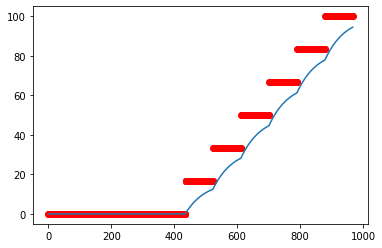

In [162]:
# sfam['MaxAbs_Shuffle'] = SFAM(alpha = 1.6567020207018912, rho = 0.037607532992751984, beta = 0.7324093401615666, epsilon = 0.0007816538021598521, uncommited_value = 0.8279089243935547)
order = 17
sfam['MaxAbs_Shuffle'] = SFAM(alpha = 776290.5535842044, rho = 0.0008149210583998265, beta = 0.5504618504091746, epsilon = 4.898721222384571e-07, uncommited_value = 0.2670182720631446)

sfam['MaxAbs_Shuffle'].shuffle_nasa_train(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392, order)
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392, order)

#### Test

0.19205607476635514

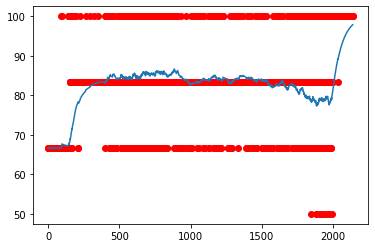

In [163]:
sfam['MaxAbs_Shuffle'].prune()
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'], -1, order)

#### Test2

0.22149532710280373

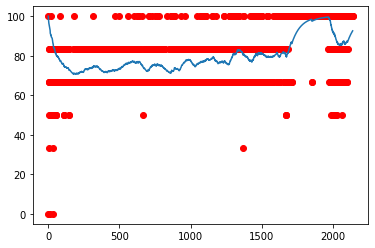

In [164]:
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['test2'][x]['MaxAbs_Cliped']['data'], -1, order)

### No teste com ufrf

[I 2021-11-08 23:58:29,591] A new study created in memory with name: no-name-f6477465-4039-4f25-ab85-48772384c2da
[I 2021-11-08 23:58:46,875] Trial 0 finished with value: 0.1510757717492984 and parameters: {'alpha': 0.10625311596261583, 'rho': 1.1478755166445598e-07, 'beta': 0.6126917801300016, 'epsilon': 2.903883599189755e-07, 'uv': 0.8327473812086221, 'order': 19}. Best is trial 0 with value: 0.1510757717492984.
[I 2021-11-08 23:59:04,269] Trial 1 finished with value: 0.1507232851143257 and parameters: {'alpha': 77934.4212495458, 'rho': 0.0006554469346967302, 'beta': 0.6744462906921087, 'epsilon': 8.322578032945101e-07, 'uv': 0.008024805740471545, 'order': 14}. Best is trial 0 with value: 0.1510757717492984.
[I 2021-11-08 23:59:21,493] Trial 2 finished with value: 0.33069399161620866 and parameters: {'alpha': 47257.09195088449, 'rho': 7.09631589369844e-07, 'beta': 0.6969830899578237, 'epsilon': 0.15803060980649802, 'uv': 0.6205448906819575, 'order': 10}. Best is trial 2 with value: 0

[I 2021-11-09 00:03:27,051] Trial 26 finished with value: 0.3294501397949674 and parameters: {'alpha': 7.1818343244002675e-09, 'rho': 0.3543088531291781, 'beta': 0.9411574030662873, 'epsilon': 7.535518905674524e-08, 'uv': 0.3359585098856616, 'order': 11}. Best is trial 7 with value: 0.33348837209302323.
[I 2021-11-09 00:03:43,663] Trial 27 finished with value: 0.3330232558139535 and parameters: {'alpha': 0.6286794835314358, 'rho': 0.008335073198073424, 'beta': 0.7305623682519237, 'epsilon': 2.444537706924886e-06, 'uv': 0.494746881470272, 'order': 7}. Best is trial 7 with value: 0.33348837209302323.
[I 2021-11-09 00:04:00,128] Trial 28 finished with value: 0.1507232851143257 and parameters: {'alpha': 0.25255249082461534, 'rho': 0.0006665251826608267, 'beta': 0.7225406808464964, 'epsilon': 2.497900671944339e-06, 'uv': 0.677793179493763, 'order': 14}. Best is trial 7 with value: 0.33348837209302323.
[I 2021-11-09 00:04:00,427] Trial 29 finished with value: 0.1510051425899953 and parameter

{'alpha': 32098.74662404218, 'rho': 0.04079029146066474, 'beta': 0.8443649735126442, 'epsilon': 9.657077310824467e-07, 'uv': 0.3676079007440835, 'order': 7}


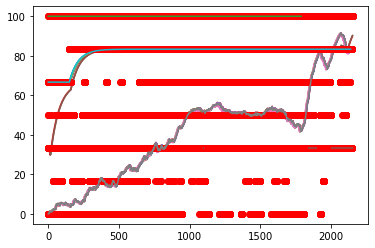

In [106]:
import optuna

def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-10, 1e+12, log=True)
    rho = trial.suggest_float("rho", 1e-10, 1e+0, log=True)
    beta = trial.suggest_float("beta", 0.5, 1e+0, log=True)
    epsilon = trial.suggest_float("epsilon", 1e-10, 1e+0, log=True)
    uncommited_value = trial.suggest_float("uv", 0.001, 1e+0)
    order = trial.suggest_int("order", 3, 20)
    
    sfam = SFAM(alpha = alpha, rho = rho, beta = beta, epsilon = epsilon, uncommited_value = uncommited_value)
    sfam.shuffle_nasa_train(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Cliped']['data'], 392, order)
    return sfam.predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'], -1, order)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print(study.best_trial.params)

# Best is trial 11 with value: 0.320596458527493. {'alpha': 4.8179476843870175, 'rho': 0.006300934375598044, 'beta': 0.8746908353941755, 'epsilon': 0.007416403995602103, 'uv': 0.6137230906894608, 'order': 11}
# Best is trial 32 with value: 0.3196644920782852. {'alpha': 3.8849255702993912, 'rho': 0.25171772646372714, 'beta': 0.9802369004005982, 'epsilon': 0.003223583859375817, 'uv': 0.9031201293244469, 'order': 11}
#  Trial 1 finished with value: 0.3091247672253259 and parameters: {'alpha': 0.6990187053883001, 'rho': 0.08047084425919833, 'beta': 0.7423731624116697, 'epsilon': 0.21014919701609575, 'uv': 0.8298748035701702, 'order': 9}. Best is trial 1 with value: 0.3091247672253259.
# Best is trial 99 with value: 0.3201304753028891. {'alpha': 4.146533021444089, 'rho': 0.34780385570064076, 'beta': 0.7381454273349647, 'epsilon': 0.0012169857086828419, 'uv': 0.6485861269372781, 'order': 11}


#### Train

0.33348837209302323

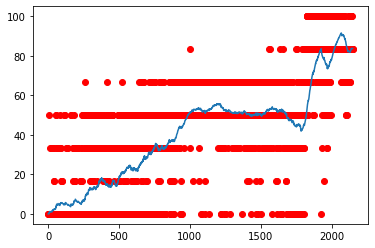

In [165]:
# order = 11
# sfam['MaxAbs_Shuffle'] = SFAM(alpha = 3.8849255702993912, rho = 0.25171772646372714, beta = 0.9802369004005982, epsilon = 0.007416403995602103, uncommited_value = 0.6137230906894608)
# order = 11
# sfam['MaxAbs_Shuffle'] = SFAM(alpha = 4.8179476843870175, rho = 0.006300934375598044, beta = 0.8746908353941755, epsilon = 0.003223583859375817, uncommited_value = 0.9031201293244469)

order = 7
sfam['MaxAbs_Shuffle'] = SFAM(alpha = 32098.74662404218, rho = 0.04079029146066474, beta = 0.8443649735126442, epsilon = 9.657077310824467e-07, uncommited_value = 0.3676079007440835)

sfam['MaxAbs_Shuffle'].shuffle_nasa_train(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Cliped']['data'], 392, order)
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'], -1, order)

#### Test - Train

0.4652351738241309

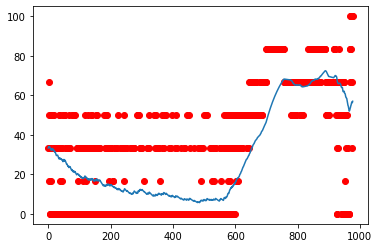

In [166]:
sfam['MaxAbs_Shuffle'].prune()
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392, order)

#### Test2

0.2386046511627907

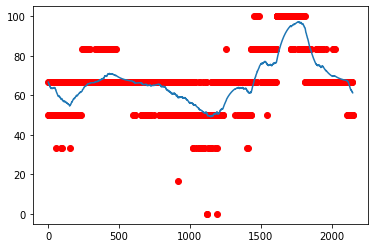

In [167]:
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['test2'][x]['MaxAbs_Cliped']['data'], -1, order)

### No teste sem ufrf

[I 2021-11-09 01:11:10,822] A new study created in memory with name: no-name-f75a09cf-e6a7-44a5-a49a-a5fffa9d863a
[I 2021-11-09 01:11:19,302] Trial 0 finished with value: 0.28544862854486286 and parameters: {'alpha': 0.011852601520626943, 'rho': 0.3474463090812728, 'beta': 0.6139844746166878, 'epsilon': 4.125220705437868e-08, 'uv': 0.4071565545184869, 'order': 6}. Best is trial 0 with value: 0.28544862854486286.
[I 2021-11-09 01:11:39,204] Trial 1 finished with value: 0.19207459207459207 and parameters: {'alpha': 111.11820087395868, 'rho': 1.0142655503355748e-05, 'beta': 0.8302980499793242, 'epsilon': 1.355619057587879e-06, 'uv': 0.6831876624943206, 'order': 12}. Best is trial 0 with value: 0.28544862854486286.
[I 2021-11-09 01:11:59,588] Trial 2 finished with value: 0.3124128312412831 and parameters: {'alpha': 2829898.617893054, 'rho': 0.6241519835106205, 'beta': 0.6425120637275017, 'epsilon': 2.987328581804279e-05, 'uv': 0.8866425543150175, 'order': 6}. Best is trial 2 with value: 0.

[I 2021-11-09 01:18:56,886] Trial 26 finished with value: 0.3084808946877912 and parameters: {'alpha': 9.923821386482762, 'rho': 4.051232340682905e-07, 'beta': 0.7655831538532433, 'epsilon': 0.15783186189910525, 'uv': 0.019807009791571906, 'order': 11}. Best is trial 12 with value: 0.31718677224033537.
[I 2021-11-09 01:19:16,627] Trial 27 finished with value: 0.31718677224033537 and parameters: {'alpha': 41630541.37750048, 'rho': 0.0006524138950559439, 'beta': 0.5875577495451183, 'epsilon': 0.029327576517327855, 'uv': 0.15736960172043601, 'order': 10}. Best is trial 12 with value: 0.31718677224033537.
[I 2021-11-09 01:19:36,104] Trial 28 finished with value: 0.31718677224033537 and parameters: {'alpha': 59426835.33386779, 'rho': 0.0003021176588380501, 'beta': 0.5936487684473212, 'epsilon': 1.494584353935449e-10, 'uv': 0.11831950600543616, 'order': 10}. Best is trial 12 with value: 0.31718677224033537.
[I 2021-11-09 01:19:40,826] Trial 29 finished with value: 0.20382462686567165 and par

{'alpha': 14324.463391596633, 'rho': 2.8120435320894876e-10, 'beta': 0.7192702154560318, 'epsilon': 0.30250629155823466, 'uv': 0.9634119255832562, 'order': 10}


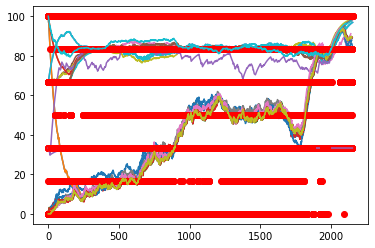

In [175]:
import optuna

def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-10, 1e+12, log=True)
    rho = trial.suggest_float("rho", 1e-10, 1e+0, log=True)
    beta = trial.suggest_float("beta", 0.5, 1e+0, log=True)
    epsilon = trial.suggest_float("epsilon", 1e-10, 1e+0, log=True)
    uncommited_value = trial.suggest_float("uv", 0.001, 1e+0)
    order = trial.suggest_int("order", 3, 20)
    
    sfam = SFAM(alpha = alpha, rho = rho, beta = beta, epsilon = epsilon, uncommited_value = uncommited_value)
    sfam.shuffle_nasa_train(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392, order)
    return sfam.predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'], -1, order)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print(study.best_trial.params)

# Best is trial 35 with value: 0.28637842863784285. {'alpha': 9.494078495031685, 'rho': 0.00026585600668354616, 'beta': 0.9262820746486281, 'epsilon': 0.00011060820265777134, 'uv': 0.6910187069818342, 'order': 6}

#### Train

0.31718677224033537

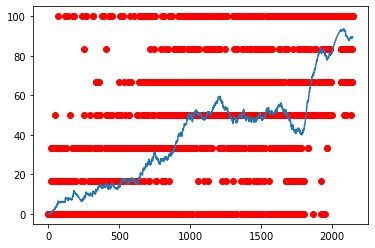

In [176]:
order = 10
sfam['MaxAbs_Shuffle'] = SFAM(alpha = 14324.463391596633, rho = 2.8120435320894876e-10, beta = 0.7192702154560318, epsilon = 0.30250629155823466, uncommited_value = 0.9634119255832562)

sfam['MaxAbs_Shuffle'].shuffle_nasa_train(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392, order)
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'], -1, order)

#### Test - Train

0.7425641025641025

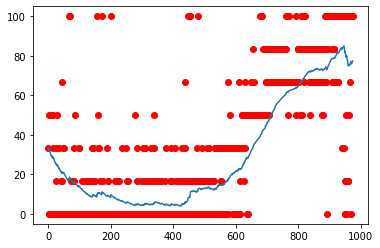

In [177]:
sfam['MaxAbs_Shuffle'].prune()
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392, order)

#### Test2

0.1527713088029809

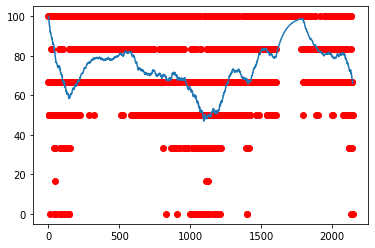

In [178]:
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['test2'][x]['MaxAbs_Cliped']['data'], -1, order)

### Try 5

In [70]:
# import optuna

# def objective(trial):
#     alpha = trial.suggest_float("alpha", 1e-10, 1e+12, log=True)
#     rho = trial.suggest_float("rho", 1e-10, 1e+0, log=True)
#     beta = trial.suggest_float("beta", 0.5, 1e+0, log=True)
#     epsilon = trial.suggest_float("epsilon", 1e-10, 1e+0, log=True)
#     uncommited_value = trial.suggest_float("uv", 0.001, 1e+0)
#     order = trial.suggest_int("order", 3, 20)
    
#     sfam = SFAM(alpha = alpha, rho = rho, beta = beta, epsilon = epsilon, uncommited_value = uncommited_value)
#     sfam.shuffle_nasa_train(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Center']['data'], 392, order)
#     return sfam.predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Center']['data'], 392, order)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)
# print(study.best_trial.params)

# # Best is trial 35 with value: 0.28637842863784285. {'alpha': 9.494078495031685, 'rho': 0.00026585600668354616, 'beta': 0.9262820746486281, 'epsilon': 0.00011060820265777134, 'uv': 0.6910187069818342, 'order': 6}

0 0.31547064305684996
[0.10611623019669121, 0.10685604490628821, 0.1049847211196829, 0.10775499486651825, 0.10742043975990119, 0.10684895818891947, 0.10415267612833726, 0.10329554651882301, 0.1085061002465892, 0.1046559455222876, 0.10499909883243518, 0.1986696428224228, 0.19277035394559647, 0.20009794798312655, 0.20184819076237046, 0.20583339828560163, 0.20116479407820378, 0.2034792505355144, 0.19243572785132187, 0.2041947929099613, 0.1943872797813904, 0.19100481893874163, 0.5524390785687955, 0.5523182644307046, 0.5522650243052901, 0.5522987582872846, 0.5523823043529338, 0.5525920616351732, 0.5529195491826522, 0.5533113621031037, 0.5537416038629399, 0.5539757274133912, 0.5543383970652757, 0.8938837698033087, 0.8931439550937118, 0.8950152788803171, 0.8922450051334817, 0.8925795602400988, 0.8931510418110805, 0.8958473238716628, 0.896704453481177, 0.8914938997534108, 0.8953440544777124, 0.8950009011675648, 0.8013303571775772, 0.8072296460544035, 0.7999020520168735, 0.7981518092376295, 0.7

[0.1459158510249847, 0.14641855807141618, 0.1421117027612835, 0.14500572489730665, 0.14369100494724518, 0.14546233652729593, 0.14446730738590868, 0.1424096542046606, 0.14173156720369107, 0.14086282570771977, 0.1389200552216281, 0.225148614685825, 0.2317141903984927, 0.2328221159398892, 0.22605071508387412, 0.23249083753414546, 0.23611883127176692, 0.22602622132792935, 0.22387720493994673, 0.22000996587818764, 0.22280568966567454, 0.2261467657017518, 0.6556784222431878, 0.6545237844060003, 0.6536335014262378, 0.653030252556555, 0.6524891902552485, 0.6523210208272706, 0.6523563359622162, 0.6527715089552513, 0.6535255600899345, 0.6545645807376606, 0.6557619050815873, 0.8540841489750153, 0.8535814419285839, 0.8578882972387165, 0.8549942751026933, 0.8563089950527548, 0.8545376634727041, 0.8555326926140914, 0.8575903457953394, 0.8582684327963089, 0.8591371742922802, 0.8610799447783719, 0.774851385314175, 0.7682858096015073, 0.7671778840601108, 0.7739492849161259, 0.7675091624658545, 0.763881

TypeError: object of type 'NoneType' has no len()

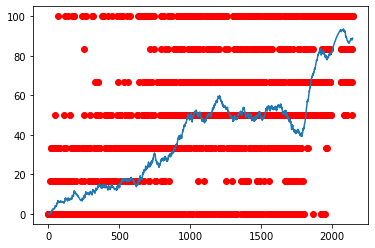

In [179]:
order = 11
sfam['MaxAbs_Shuffle'] = SFAM(alpha = 1.6567020207018912, rho = 0.037607532992751984, beta = 0.7324093401615666, epsilon = 0.0007816538021598521, uncommited_value = 0.8279089243935547)

for i in range(10):
    sfam['MaxAbs_Shuffle'].shuffle_nasa_train(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392, order)
    print(i, sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'], -1, order))
    
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'], -1, order)

0.31547064305684996

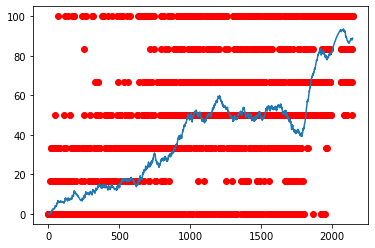

In [90]:
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'], -1, order)

0.16542404473438957

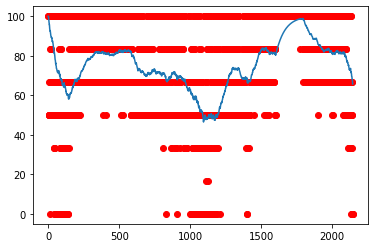

In [91]:
sfam['MaxAbs_Shuffle'].predict_nasa(lambda x: datasets['test2'][x]['MaxAbs_Cliped']['data'], -1, order)

# Testando novos parâmetros para Weibull

In [74]:
# import optuna

# def objective(trial):
#     alpha = trial.suggest_float("alpha", 1e-4, 1e+1, log=True)
#     rho = trial.suggest_float("rho", 1e-4, 1e+0, log=True)
#     beta = trial.suggest_float("beta", 0.5, 1e+0, log=True)
#     epsilon = trial.suggest_float("epsilon", 1e-4, 1e+0, log=True)
#     uncommited_value = trial.suggest_float("uv", 0.5, 1e+0)
#     order = trial.suggest_int("order", 3, 20)
    
#     sfam = SFAM(alpha = alpha, rho = rho, beta = beta, epsilon = epsilon, uncommited_value = uncommited_value)
#     sfam.shuffle_nasa_train(lambda x: datasets['train'][x]['MaxAbs_Center']['data'], 392, order)
#     return sfam.predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Center']['data'], -1, order)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)
# print(study.best_trial.params)

# # Best is trial 35 with value: 0.28637842863784285. {'alpha': 9.494078495031685, 'rho': 0.00026585600668354616, 'beta': 0.9262820746486281, 'epsilon': 0.00011060820265777134, 'uv': 0.6910187069818342, 'order': 6}

In [75]:
# import optuna

# def objective(trial):
#     b = trial.suggest_float("b", 1e-5, 1e+5, log=True)
#     n = trial.suggest_float("n", 1e-5, 1e+5, log=True)
#     y = trial.suggest_float("y", 1e-5, 1e+5, log=True)
#     k = trial.suggest_float("k", 1e-5, 1e+5, log=True)

#     error = 0
#     try:
#         for i in range(len(datasets['train']['rms']['data'])):
#             error += (datasets['train']['rms']['data'][i] - ufrf(i, b, n, y, k))**2
#     except BaseException as err:
#         print(err)
#         return float('inf')
#     return error
                  
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=10000)
# print(study.best_trial.params)
# # for i in range(len(datasets['train']['rms']['data'])):
# #     datasets['train']['rms']['ufrf']['data'].append(ufrf(i, 12.0917, 281.0209, 0.0773, 1.38e-5))
# #     datasets['train']['kurtosis']['ufrf']['data'].append(ufrf(i, 11.8280, 86.7537,  3.4471, 3.8e-10))
# #     datasets['train']['rmsee']['ufrf']['data'].append(ufrf(i, 5.0,  100.0, 0.19796, 3.55e-4))
    

In [76]:
# import optuna

# def objective(trial):
#     b = trial.suggest_float("b", 1e-10, 1e+10, log=True)
#     n = trial.suggest_float("n", 1e-10, 1e+10, log=True)
#     y = trial.suggest_float("y", 1e-10, 1e+10, log=True)
#     k = trial.suggest_float("k", 1e-10, 1e+10, log=True)

#     error = 0
#     try:
#         for i in range(len(datasets['train']['kurtosis']['data'])):
#             error += (datasets['train']['kurtosis']['data'][i] - ufrf(i, b, n, y, k))**2
#     except BaseException as err:
#         print(err)
#         return float('inf')
#     return error
                  
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=12000)
# print(study.best_trial.params)
# # for i in range(len(datasets['train']['rms']['data'])):
# #     datasets['train']['rms']['ufrf']['data'].append(ufrf(i, 12.0917, 281.0209, 0.0773, 1.38e-5))
# #     datasets['train']['kurtosis']['ufrf']['data'].append(ufrf(i, 11.8280, 86.7537,  3.4471, 3.8e-10))
# #     datasets['train']['rmsee']['ufrf']['data'].append(ufrf(i, 5.0,  100.0, 0.19796, 3.55e-4))
    

In [77]:
# import optuna

# def objective(trial):
#     b = trial.suggest_float("b", 1e-10, 1e+10, log=True)
#     n = trial.suggest_float("n", 1e-10, 1e+10, log=True)
#     y = trial.suggest_float("y", 1e-10, 1e+10, log=True)
#     k = trial.suggest_float("k", 1e-10, 1e+10, log=True)

#     error = 0
#     try:
#         for i in range(len(datasets['train']['rmsee']['data'])):
#             error += (datasets['train']['rmsee']['data'][i] - ufrf(i, b, n, y, k))**2
#     except BaseException as err:
#         print(err)
#         return float('inf')
#     return error
                  
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=12000)
# print(study.best_trial.params)
# # for i in range(len(datasets['train']['rms']['data'])):
# #     datasets['train']['rms']['ufrf']['data'].append(ufrf(i, 12.0917, 281.0209, 0.0773, 1.38e-5))
# #     datasets['train']['kurtosis']['ufrf']['data'].append(ufrf(i, 11.8280, 86.7537,  3.4471, 3.8e-10))
# #     datasets['train']['rmsee']['ufrf']['data'].append(ufrf(i, 5.0,  100.0, 0.19796, 3.55e-4))
    

In [78]:
# import optuna

# def objective(trial):
#     b = trial.suggest_float("b", 1e-10, 1e+10, log=True)
#     n = trial.suggest_float("n", 1e-10, 1e+10, log=True)
#     y = trial.suggest_float("y", 1e-10, 1e+10, log=True)
#     k = trial.suggest_float("k", 1e-10, 1e+10, log=True)

#     error = 0
#     try:
#         for i in range(len(datasets['train']['rms']['data'])):
#             error += (datasets['train']['rms']['data'][i] - ufrf(i, b, n, y, k))**2
#     except BaseException as err:
#         print(err)
#         return float('inf')
#     return error
                  
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=12000)
# print(study.best_trial.params)
# # for i in range(len(datasets['train']['rms']['data'])):
# #     datasets['train']['rms']['ufrf']['data'].append(ufrf(i, 12.0917, 281.0209, 0.0773, 1.38e-5))
# #     datasets['train']['kurtosis']['ufrf']['data'].append(ufrf(i, 11.8280, 86.7537,  3.4471, 3.8e-10))
# #     datasets['train']['rmsee']['ufrf']['data'].append(ufrf(i, 5.0,  100.0, 0.19796, 3.55e-4))
    

In [79]:



# import optuna

# def objective(trial):
#     b = trial.suggest_float("b", 1e-10, 1e+10, log=True)
#     n = trial.suggest_float("n", 1e-10, 1e+10, log=True)
#     y = trial.suggest_float("y", 1e-10, 1e+10, log=True)
#     k = trial.suggest_float("k", 1e-10, 1e+10, log=True)

#     error = 0
#     try:
#         for i in range(len(datasets['train']['kurtosis']['data'])):
#             error += (datasets['train']['kurtosis']['data'][i] - ufrf(i, b, n, y, k))**2
#     except BaseException as err:
#         print(err)
#         return float('inf')
#     return error
                  
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=25000)
# print(study.best_trial.params)
# # for i in range(len(datasets['train']['rms']['data'])):
# #     datasets['train']['rms']['ufrf']['data'].append(ufrf(i, 12.0917, 281.0209, 0.0773, 1.38e-5))
# #     datasets['train']['kurtosis']['ufrf']['data'].append(ufrf(i, 11.8280, 86.7537,  3.4471, 3.8e-10))
# #     datasets['train']['rmsee']['ufrf']['data'].append(ufrf(i, 5.0,  100.0, 0.19796, 3.55e-4))
    

In [80]:
# Trial 13109 finished with value: 651.8197403775264 and parameters: {'b': 3.1647763222847693, 'n': 9655.298502441472, 'y': 3.3565863046236797, 'k': 686924.7810499861}. Best is trial 13109 with value: 651.8197403775264.

In [81]:
# datasets['train']['rms']['ufrf2'] = {}
# datasets['train']['kurtosis']['ufrf2'] = {}
# datasets['train']['rmsee']['ufrf2'] = {}

# datasets['train']['rms']['ufrf2']['data'] = []
# datasets['train']['kurtosis']['ufrf2']['data'] = []
# datasets['train']['rmsee']['ufrf2']['data'] = []

# for i in range(len(datasets['train']['rms']['data'])):
#     datasets['train']['rms']['ufrf2']['data'].append(ufrf(i, 14.229038186252977, 668.782319256043, 0.08808774870823785, 0.06837028155861612))
#     datasets['train']['kurtosis']['ufrf2']['data'].append(ufrf(i, 3.1647763222847693, 8965.298502441472, 3.3565863046236797, 686924.7810499861))
#     datasets['train']['rmsee']['ufrf2']['data'].append(ufrf(i, 1.9853779542341599,  111560.79648079904, 0.15513975802213667, 904791.9996814801))
    
# datasets['train']['rms']['ufrf2']['data'] = np.array(datasets['train']['rms']['ufrf2']['data'])
# datasets['train']['kurtosis']['ufrf2']['data'] = np.array(datasets['train']['kurtosis']['ufrf2']['data'])
# datasets['train']['rmsee']['ufrf2']['data'] = np.array(datasets['train']['rmsee']['ufrf2']['data'])

# fig, axs = plt.subplots(1, 3, figsize=((16, 3)))

# for i in range(len(datas)):
#     axs[i].plot(datasets['train'][datas[i]]['data'])
#     axs[i].plot(datasets['train'][datas[i]]['ufrf2']['data'])
#     axs[i].set_title(datas[i] + ' train')

In [82]:
# def ufrf(t, b, n, y, k):
#     return y+(k*(b/(n**b))*(t**(b-1)))